In [1]:
#from synoptic.services import stations_timeseries, stations_nearesttime, stations_latest
from pprint import pprint
from datetime import datetime
import datetime
import pytz
import pandas as pd
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import html5lib
import lxml

from herbie.archive import Herbie
from herbie import FastHerbie
from synoptic.services import stations_timeseries
from synoptic.plots import plot_timeseries, plot_timeseries_wind, map_timeseries
from synoptic.services import stations_metadata

import sys
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LogNorm, Normalize, from_levels_and_colors, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.ticker as ticker
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature , COLORS , OCEAN, ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import xarray as xr
import numpy as np
from netCDF4 import Dataset,MFDataset
from wrf import (to_np, getvar, smooth2d, get_cartopy,vertcross, cartopy_xlim, 
    cartopy_ylim, latlon_coords, ALL_TIMES, uvmet, interplevel, CoordPair, interpline, 
    ll_to_xy, xy_to_ll, extract_global_attrs,extract_times)
from wrf.g_rh import get_rh, get_rh_2m
import pandas as pd 
import os
from datetime import timedelta
import datetime
from glob import glob
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['figure.dpi'] = 150
import warnings
import seaborn as sns

import time
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen
from wind import uv_to_spddir

In [2]:
from glob import glob
from netCDF4 import Dataset,MFDataset
from wrf import (to_np, getvar, smooth2d, get_cartopy,vertcross, cartopy_xlim, 
    cartopy_ylim, latlon_coords, ALL_TIMES, uvmet, interplevel, CoordPair, interpline, 
    ll_to_xy, xy_to_ll, extract_global_attrs,extract_times)
import numpy as np
from wrf.g_rh import get_rh, get_rh_2m
from datetime import timedelta
import time
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

In [3]:
def heatindex(tin, rhin):

    original_shape = tin.shape

    # Convert to Farenheit
    # t = wv.K2F(tin.ravel())

    t = tin.ravel()
    rh = rhin.ravel()

    rh[rh > 100] = 100  # Truncate RH range to 100% (eqn is an approx.)

    # Initial guess for the Heat index

    hi_initial = 0.5 * (t + 61.0 + (t - 68.0) * 1.2 + rh * .094)

    # Our conditions for applying the different eqns and corrections for the
    # Heat Index

    cond0mask = (hi_initial + t) / 2 >= 80.
    cond1mask = (t[cond0mask] > 80) & (t[cond0mask] < 112) \
        & (rh[cond0mask] < 13)

    cond2mask = (rh[cond0mask] > 85) & (t[cond0mask] > 80) \
        & (t[cond0mask] < 87)

    # Initialize zero-arrays that we'll fill out depending on the
    # condition masks.

    hi = np.zeros(t.shape, dtype=np.float32)
    hi_baseline = np.zeros(t.shape, dtype=np.float32)
    adj = np.zeros(t.shape, dtype=np.float32)

    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -.22475541
    c5 = -6.83783e-3
    c6 = -5.481717e-2
    c7 = 1.22873e-3
    c8 = 8.5282e-4
    c9 = -1.99e-6

    hi_baseline[cond0mask] = c1 + c2 * t[cond0mask] + c3 \
        * rh[cond0mask] + c4 * t[cond0mask] * rh[cond0mask] + c5 \
        * t[cond0mask] ** 2 + c6 * rh[cond0mask] ** 2 + c7 \
        * rh[cond0mask] * t[cond0mask] ** 2 + c8 * t[cond0mask] \
        * rh[cond0mask] ** 2 + c9 * t[cond0mask] ** 2 * rh[cond0mask] \
        ** 2

    adj[cond0mask][cond1mask] = -((13 - rh[cond0mask][cond1mask]) / 4) \
        * np.sqrt((17 - np.abs(t[cond0mask][cond1mask] - 95)) / 17.0)

    adj[cond0mask][cond2mask] = (rh[cond0mask][cond2mask] - 85) / 10 \
        * ((87 - t[cond0mask][cond2mask]) / 5.0)

    # The HI with condition 0 (cond0mask) is in the form baseline + adjustment

    hi[cond0mask] = hi_baseline[cond0mask] + adj[cond0mask]
    hi[~cond0mask] = hi_initial[~cond0mask]

    return hi.reshape(original_shape)


In [4]:
def error_metrics(actual_inp, ideal_inp):
    actual = actual_inp[~np.isnan(actual_inp)]
    ideal = ideal_inp[~np.isnan(actual_inp)] 
    
    correlation_matrix = np.corrcoef(actual, ideal)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    
    MSE=np.mean((actual - ideal)**2)
    RMSE=np.sqrt(MSE)
    MAE=np.mean(np.absolute(actual - ideal))
    
    return r_squared,MSE,RMSE,MAE;

In [5]:
def get_data_ASOS(startf,endf):    
    
    ####### ASOS ######## ---------------------------------------------------------------------------------------------------------------------------------------------------------
    MAX_ATTEMPTS = 6
    # HTTPS here can be problematic for installs that don't have Lets Encrypt CA
    SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

    # Specify your stations here. These are the 31 nearest stations to Houston
    stations = ['UTS','11R','CXO','6R3','DWH','IAH','BYY','LBX','GLS','ARM','AXH','LVJ','EFD','HOU','ELA','66R','SGR','MCJ',
               'TME','T78','BMT','BPT','RPE','ORG','CRH','GVX','BQX','PSX','CLL','CFD','3T5']
    
    stations = ['GLS','HOU','MCJ','IAH','DWH','CXO','UTS']
    # stations = ['HOU','ELA','GLS']

    # timestamps in UTC to request data for

    #                          year mon day hour min
    startts = startf
    endts = endf + datetime.timedelta(days=1)

    def download_data(uri):
        attempt = 0
        while attempt < MAX_ATTEMPTS:
            try:
                data = urlopen(uri, timeout=300).read().decode("utf-8")
                if data is not None and not data.startswith("ERROR"):
                    return data
            except Exception as exp:
                print("download_data(%s) failed with %s" % (uri, exp))
                time.sleep(5)
            attempt += 1

        print("Exhausted attempts to download, returning empty data")
        return ""

    """Our main method"""
    # timestamps in UTC to request data for
    #service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"
    service = SERVICE + "data=sknt&data=p01i&data=alti&data=feel&data=drct&data=relh&data=dwpf&data=tmpf&tz=Etc/UTC&format=onlycomma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&hour1=%H&minute1=%M&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&hour2=%H&minute2=%M&")
    #'michael.bartsevich/SynopticPy/notebooks/ASOS_Auto/CSVs'
    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()

    #stations = ['HOU']
    # stations = get_stations_from_filelist("mystations.txt")
    for station in stations:
        uri = "%s&station=%s" % (service, station)
        print("Downloading: %s" % (station,))
        data = download_data(uri)
        outfn = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ASOS_CSVs/%s.csv" % (station)
        out = open(outfn, "w")
        out.write(data)
        out.close()

    print('Download finished')


        # main()
    # Creates a dictionary of dataframes from all the .csv files we just downloaded
    station_wx_dict = {}
    zero_list = []
    for i in stations:
        i_wx = pd.read_csv("/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ASOS_CSVs/%s.csv" % i, 
            parse_dates=['valid'],
            dtype= {'station' : 'category',
                   '  tmpf ': 'category',
                   '  dwpf ': 'category',
                   '  sknt ': 'category',
                   '  relh ': 'category',
                   '  drct ': 'category',
                   '  p01i ': 'category',
                   '  alti ': 'category',
                   '  feel ': 'category',
                   '  lon  ': 'category',
                   '  lat  ': 'category'}
            ).rename(columns=lambda x: x.strip())
        station_wx_dict[i] = i_wx
        if len(i_wx) == 0:
            zero_list.append(i)
    if zero_list != []:
        print('DISCLAIMER:\n\nThe following stations have no data\nmost likely because they didnt exist\nduring the given time range:\n\n',zero_list)

    df_list = []
    # Set the date as the index
    for i in stations:
        df = station_wx_dict[i]
        df['valid'] = pd.to_datetime(df['valid'])
        df = df.set_index('valid')
    # Creates a list of dataframes
        df_list.append(df)
    # Combines all the dataframes into one and sorts by date
    df_all = pd.concat(df_list)
    df_all = df_all.sort_values(by="valid")

    # Now we have a dataframe of all the stations and their data over that given time range

    df_all.rename(columns={'station': 'Station', 'lon': 'long','sknt':'Wind Speed','drct':'Resultant Wind Direction','tmpf':'Outdoor Temperature','relh':'Relative Humidity'},
                  inplace=True)
    df_all.drop(['p01i', 'alti','feel','dwpf'], axis=1, inplace=True)
    cols=['Station','lat','long','Outdoor Temperature','Resultant Wind Direction','Wind Speed','Relative Humidity']
    df_all = df_all[cols]
    df_all['source']='ASOS'
    df_asos=df_all
    df_asos.index.names = ['DATETIME']
    
    return df_asos, stations

# Outdoor Temperature	 = Fahrenheit
# Relative Humidity = percent
# Wind Speed	 = Knots
# Resultant Wind Direction  = degree

In [6]:
date_list = []
startf = datetime.datetime(2022, 8, 25, 0, 0)
while startf !=  datetime.datetime(2022, 8, 31, 0, 0):
    x = (startf,startf+datetime.timedelta(days=2))
    date_list.append(x)
    startf = startf + datetime.timedelta(days=1)

In [7]:
date_list

[(datetime.datetime(2022, 8, 25, 0, 0), datetime.datetime(2022, 8, 27, 0, 0)),
 (datetime.datetime(2022, 8, 26, 0, 0), datetime.datetime(2022, 8, 28, 0, 0)),
 (datetime.datetime(2022, 8, 27, 0, 0), datetime.datetime(2022, 8, 29, 0, 0)),
 (datetime.datetime(2022, 8, 28, 0, 0), datetime.datetime(2022, 8, 30, 0, 0)),
 (datetime.datetime(2022, 8, 29, 0, 0), datetime.datetime(2022, 8, 31, 0, 0)),
 (datetime.datetime(2022, 8, 30, 0, 0), datetime.datetime(2022, 9, 1, 0, 0))]

In [5]:
def get_data_SYNO(startf,endf):  
    
    ##### Synoptic ##### ---------------------------------------------------------------------------------------------------------------------------------------------------------
    a = stations_latest(radius='kmcj,30')
    transpose_a = a.T
    df = transpose_a[transpose_a["STATE"].str.contains("date_time") == False]
    variables=['air_temp','wind_direction','wind_speed','relative_humidity','NO2_concentration','ozone_concentration']
    df2 = pd.DataFrame().assign(STID=df['STID'], latitude=df['latitude'],longitude=df['longitude'])
    id_lst=df2['STID'].tolist()
    b = stations_timeseries(start=startf, end=endf,
                            vars=variables,
                            stid=id_lst,
                            # stid=['KDWH', 'KEFD'],
                            units='english',
                            qc_checks='all',
                            obtimezone='UTC')
    # Adds 3 columns giving the coords of each station
    for i in range(len(b)):
        b[i]['STID']=b[i].attrs['STID']
        b[i]['lat']=b[i].attrs['latitude']
        b[i]['lon']=b[i].attrs['longitude']
    big_boy = pd.concat(b)
    big_boy=big_boy.sort_values(by=['date_time','STID'])
    lst=['STID','lat','lon','air_temp','wind_direction','wind_speed','relative_humidity']
    big_boy = big_boy[lst]
    big_boy.rename(columns={'STID': 'Station', 'lon': 'long','wind_speed':'Wind Speed','wind_direction':'Resultant Wind Direction','air_temp':'Outdoor Temperature','relative_humidity':'Relative Humidity'},
                  inplace=True)
    big_boy['source']='Syno'
    df=big_boy.reset_index()
    def remove_timezone(dt):
        return dt.replace(tzinfo=None)
    df['date_time'] = df['date_time'].apply(remove_timezone)
    df=df.set_index('date_time')
    df_syno=df
    df_syno.index=list(df_syno.index.strftime('%Y-%m-%d %H:%M:%S'))
    df_syno.index.names = ['DATETIME']
    df_syno.index = pd.to_datetime(df_syno.index)
    
    return df_syno
# Outdoor Temperature	 = Fahrenheit
# Relative Humidity = percent
# Wind Speed	 = Knots
# Resultant Wind Direction  = degree

In [6]:
def get_data_TCEQ(startf, endf):

    ##### TCEQ ##### ---------------------------------------------------------------------------------------------------------------------------------------------------------
    tceq_site_data_url = (
        "https://www.tceq.texas.gov/cgi-bin/compliance/monops/daily_summary.pl"
    )
    tceq_sites_url = (
        "https://www17.tceq.texas.gov/tamis/index.cfm?fuseaction=report.site_list&sort=AQS_SITE_CD&order"
        "=asc&formSub=1&cams=checked&TCEQRegion=checked&siteName=checked&strAddr=checked&cityName"
        "=checked&zipCode=checked&cntyName=checked&lat=checked&long=checked&latLongType=dec&actDT"
        "=checked&urbanArea=checked&ownByName=checked&EPARegistered=checked&showActiveOnly=1&regFilter"
        "=&cntyFilter=&camsFilter= "
    )

    # Edit the start and end date here
    start_date = startf + datetime.timedelta(days=-1, hours=5)
    end_date = endf + datetime.timedelta(days=1, hours=5)
    number_of_days = (end_date - start_date).days

    date_list = []
    for day in range(number_of_days):
        a_date = start_date + datetime.timedelta(days=day)
        date_list.append(a_date)

    # Creates a df of the nearest active stations and their metadata
    dfs1 = pd.read_html(tceq_sites_url)
    table1 = dfs1[-1]
    longlat = (
        (table1["Latitude"] > 28.8586)
        & (table1["Latitude"] < 30.6484)
        & (table1["Longitude"] > -96.4685)
        & (table1["Longitude"] < -94.2694)
    )
    nearby = table1.loc[longlat]
    nearby["Activation Date"] = pd.to_datetime(nearby["Activation Date"])
    active_nearby = nearby.loc[(nearby["Activation Date"] < "2018-06-01")]
    for i in active_nearby.index:
        active_nearby["CAMS"][i] = active_nearby["CAMS"][i][0:4]

    # Lists the station IDs
    st_ids_str = []
    for i in active_nearby["CAMS"].index:
        st_ids_str.append(active_nearby["CAMS"][i][0:4])

    #%%time
    datasets = []
    check = {"worked": 0, "no_vars": 0, "no_data": 0}
    index_time = [
        "0000",
        "0100",
        "0200",
        "0300",
        "0400",
        "0500",
        "0600",
        "0700",
        "0800",
        "0900",
        "1000",
        "1100",
        "1200",
        "1300",
        "1400",
        "1500",
        "1600",
        "1700",
        "1800",
        "1900",
        "2000",
        "2100",
        "2200",
        "2300",
    ]
    # iterates through the date range
    for i in range(len(date_list)):
        datemonth = date_list[i].month
        dateday = date_list[i].day
        dateyear = date_list[i].year
        # for each date it iterates through all the stations
        print(date_list[i], "initiated")
        # for st in st_ids_str[16:20]:
        for st in st_ids_str:
            name = active_nearby.loc[active_nearby["CAMS"] == st, "Site Name"].iloc[0]
            lat = active_nearby.loc[active_nearby["CAMS"] == st, "Latitude"].iloc[0]
            long = active_nearby.loc[active_nearby["CAMS"] == st, "Longitude"].iloc[0]
            print("     ", name, st, "station initiated")
            params = {
                "select_date": "user",
                "user_month": datemonth - 1,  # TCEQ has a weird offset.
                "user_day": dateday,
                "user_year": dateyear,
                "select_site": "|||" + str(int(st)),
                "time_format": "24hr",
            }
            resp = requests.get(tceq_site_data_url, params=params)
            html = BeautifulSoup(resp.text, "html.parser").prettify()
            # Checks if the site has data based on html length
            if len(html) > 100000:
                # Creates an instance of a dataframe
                df = pd.read_html(html, header=0)[-1]
                df = df.set_index("Parameter Measured")
                # Boolean statements to use for checking if data has the variables we want
                temp_bool = "Outdoor Temperature" in df.index
                drct_bool = "Resultant Wind Direction" in df.index
                spee_bool = "Wind Speed" in df.index
                NO2_bool = "Nitrogen Dioxide" in df.index
                O3_bool = "Ozone" in df.index
                RH_bool = "Relative Humidity" in df.index
                # Creates single-column dataframes from main dataframe based on variables we want.
                # If variables don't exist, it fills the column with NaN.
                if temp_bool == True:
                    df_T = df.loc["Outdoor Temperature"]
                    df_T = df_T.to_frame()
                    df_T = df_T.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Outdoor Temperature": ["NaN"] * 24}
                    df_T = pd.DataFrame(data, index=index_time)

                if drct_bool == True:
                    df_D = df.loc["Resultant Wind Direction"]
                    df_D = df_D.to_frame()
                    df_D = df_D.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Resultant Wind Direction": ["NaN"] * 24}
                    df_D = pd.DataFrame(data, index=index_time)

                if spee_bool == True:
                    df_S = df.loc["Wind Speed"]
                    df_S = df_S.to_frame()
                    df_S = df_S.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Wind Speed": ["NaN"] * 24}
                    df_S = pd.DataFrame(data, index=index_time)

                if NO2_bool == True:
                    df_N = df.loc["Nitrogen Dioxide"]
                    df_N = df_N.to_frame()
                    df_N = df_N.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Nitrogen Dioxide": ["NaN"] * 24}
                    df_N = pd.DataFrame(data, index=index_time)

                if O3_bool == True:
                    df_O = df.loc["Ozone"]
                    df_O = df_O.to_frame()
                    df_O = df_O.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Ozone": ["NaN"] * 24}
                    df_O = pd.DataFrame(data, index=index_time)

                if RH_bool == True:
                    df_RH = df.loc["Relative Humidity"]
                    df_RH = df_RH.to_frame()
                    df_RH = df_RH.drop(["Parameter Measured.1", "POC"])
                else:
                    data = {"Relative Humidity": ["NaN"] * 24}
                    df_RH = pd.DataFrame(data, index=index_time)

                # Combines the column dataframes into a single dataframe
                df = pd.concat([df_T, df_D, df_S, df_N, df_O, df_RH], axis=1)
                df = df.rename_axis(None, axis=1)
                df.index.names = ["DATETIME"]
                df["Station"] = name
                df["lat"] = lat
                df["long"] = long
                # cols = df.columns.tolist()
                cols = [
                    "Station",
                    "lat",
                    "long",
                    "Outdoor Temperature",
                    "Resultant Wind Direction",
                    "Wind Speed",
                    "Nitrogen Dioxide",
                    "Ozone",
                    "Relative Humidity",
                ]
                # cols = cols[-1:] + cols[:-1]
                df = df[cols]

                for j in range(0, len(df.index)):
                    df.rename(
                        index={
                            df.index[j]: str(dateyear)
                            + "-"
                            + str(datemonth)
                            + "-"
                            + str(dateday)
                            + " "
                            + df.index[j][0:2]
                            + ":"
                            + df.index[j][2:]
                        },
                        inplace=True,
                    )

                df.index = pd.to_datetime(df.index)

                # Appends the dataframe instance to the list of dataframes
                datasets.append(df)
                print("     ", name, st, "station complete")
                check["worked"] = check["worked"] + 1
            else:
                print("     ", name, st, "station has no data")
                check["no_data"] = check["no_data"] + 1
                pass
        print(date_list[i], "completed\n")
    print(check)

    # The holy grail...
    big_boy = pd.concat(datasets)
    big_boy = big_boy.sort_values(by=["DATETIME", "Station"])
    big_boy["source"] = "TCEQ"
    df = big_boy
    df.index = df.index.tz_localize("US/Central").tz_convert(None)
    df = df.reset_index()
    df = df.loc[(df["DATETIME"] >= str(startf)) & (df["DATETIME"] <= str(endf))]
    df = df.set_index("DATETIME")
    df_tceq = df

    return df_tceq


# Outdoor Temperature	 = Fahrenheit
# Relative Humidity = percent
# Wind Speed	 = Miles / Hour
# Resultant Wind Direction  = degree

## Get WRF data

In [ ]:
emp_lst=[]
for month in range(6,9):
    for day in range(1,31):
        startf=datetime.datetime(2022, month, day, 0, 0)

        # startf=datetime.datetime(2022, 7, 27, 11, 0) 
        # endf=datetime.datetime(2022, 7, 29, 4, 0)

        #base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/2022/06/22/"
        base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/{}/{}/{}/".format(startf.isoformat()[0:4],startf.isoformat()[5:7],startf.isoformat()[8:10])
        Case_A_path = base_path 
        files_Case_A = sorted(glob(Case_A_path+'/wrfout_d02**'))
        files_Case_A_dataset=[Dataset(item) for item in files_Case_A]

        Land_mask = getvar(files_Case_A_dataset, 'LU_INDEX', timeidx=ALL_TIMES, method="cat")
        temp = Land_mask [15] .data
        temp[temp == 17] =np.nan 
        temp[temp > 0] = 1

        lats, lons = latlon_coords(Land_mask)
        cart_proj = get_cartopy(Land_mask)

        t2_Case_A = getvar(files_Case_A_dataset, 'T2', timeidx=ALL_TIMES, method="cat")
        temp_t2_Case_A = (t2_Case_A - 273.15) * (9.0/5.0) + 32.0
        rh2_Case_A = getvar(files_Case_A_dataset, 'rh2', timeidx=ALL_TIMES, method="cat")
        uvmet10_Case_A = getvar(files_Case_A_dataset, "uvmet10", units="kts", timeidx=ALL_TIMES, method="cat")
        wspd_wdir10_Case_A = getvar(files_Case_A_dataset, "uvmet10_wspd_wdir", units="kts", timeidx=ALL_TIMES, method="cat")
        rh_Case_A = get_rh_2m(files_Case_A_dataset,timeidx=ALL_TIMES, method="cat")

        time_list_temp = [x / 1e9 for x in Land_mask['Time'][:].values.tolist()]
        timelist = [datetime.datetime.utcfromtimestamp(element) for element in time_list_temp]
        start =datetime.datetime.utcfromtimestamp(time_list_temp[0])
        end = datetime.datetime.utcfromtimestamp(time_list_temp[-1])
        duration = end - start                         # For build-in functions
        duration_in_s = duration.total_seconds()  
        hours_span = divmod(duration_in_s, 3600)[0] 
        date_generated = [start + timedelta(hours=x) for x in range(0, int(hours_span))]
        k = str(len(date_generated)) + ' ' + str(date_generated[0])
        print(k)
        emp_lst.append(k)


In [ ]:
for dates in date_list:
    try:
        startf = dates[0]
        endf = dates[1]
        print(startf, 'initialized')
        base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/{}/{}/{}/".format(startf.isoformat()[0:4],startf.isoformat()[5:7],startf.isoformat()[8:10])
        Case_A_path = base_path 
        files_Case_A = sorted(glob(Case_A_path+'/wrfout_d02**'))
        files_Case_A_dataset=[Dataset(item) for item in files_Case_A]

        Land_mask = getvar(files_Case_A_dataset, 'LU_INDEX', timeidx=ALL_TIMES, method="cat")
        temp = Land_mask [15] .data
        temp[temp == 17] =np.nan 
        temp[temp > 0] = 1

        lats, lons = latlon_coords(Land_mask)
        cart_proj = get_cartopy(Land_mask)

        t2_Case_A = getvar(files_Case_A_dataset, 'T2', timeidx=ALL_TIMES, method="cat")
        temp_t2_Case_A = (t2_Case_A - 273.15) * (9.0/5.0) + 32.0
        rh2_Case_A = getvar(files_Case_A_dataset, 'rh2', timeidx=ALL_TIMES, method="cat")
        uvmet10_Case_A = getvar(files_Case_A_dataset, "uvmet10", units="kts", timeidx=ALL_TIMES, method="cat")
        wspd_wdir10_Case_A = getvar(files_Case_A_dataset, "uvmet10_wspd_wdir", units="kts", timeidx=ALL_TIMES, method="cat")
        rh_Case_A = get_rh_2m(files_Case_A_dataset,timeidx=ALL_TIMES, method="cat")

        time_list_temp = [x / 1e9 for x in Land_mask['Time'][:].values.tolist()]
        timelist = [datetime.datetime.utcfromtimestamp(element) for element in time_list_temp]
        start =datetime.datetime.utcfromtimestamp(time_list_temp[0])
        end = datetime.datetime.utcfromtimestamp(time_list_temp[-1])
        duration = end - start                         # For build-in functions
        duration_in_s = duration.total_seconds()  
        hours_span = divmod(duration_in_s, 3600)[0] 
        date_generated = [start + timedelta(hours=x) for x in range(0, int(hours_span))]

        if sorted(glob(Case_A_path+'/hrrr.t06z**'))==[]:
            hour = 0
        else:
            hour = 6
        print('init_hour =',hour)
        #DATES = pd.date_range(start=date_generated[0].isoformat(), periods=1, freq="6H")
        DATES = pd.date_range(start=datetime.datetime(date_generated[0].year, date_generated[0].month, date_generated[0].day, hour, 0), periods=1, freq="6H")
        #fxx = range(len(date_generated))
        fxx = range(48)
        FH = FastHerbie(DATES, model="hrrr", fxx=fxx ,  max_threads = 16, verbose = "True")

        #base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/{}/{}/{}/".format(startf.isoformat()[0:4],startf.isoformat()[5:7],startf.isoformat()[8:10])
        grib_dir = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_grib'
        test_path = grib_dir + '/hrrr/{}/'.format(startf.isoformat()[0:4]+startf.isoformat()[5:7]+startf.isoformat()[8:10])

        print('TMP S')
        FH.download("TMP:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
        if zero_files:
            FH.download("TMP:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        else:
            pass
        ds = FH.xarray("TMP:2 m")
        t2m_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_T2m.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
        ds.to_netcdf(t2m_cdf_path)
        print('TMP E')

        print('UV S')
        FH.download("(?:U|V)GRD:10 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
        if zero_files:
            FH.download("(?:U|V)GRD:10 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        else:
            pass
        ds = FH.xarray("(?:U|V)GRD:10 m",max_threads = 16)
        uv_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_UV10.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
        ds.to_netcdf(uv_cdf_path)
        print('UV E')

        print('RH S')
        FH.download("RH:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
        if zero_files:
            FH.download("RH:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
        else:
            pass
        ds = FH.xarray("RH:2 m",max_threads = 16,)
        rh_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_RH2m.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
        ds.to_netcdf(rh_cdf_path)
        print('RH E')

        ds_t = xr.open_dataset(t2m_cdf_path)
        ds_uv = xr.open_dataset(uv_cdf_path)
        ds_rh = xr.open_dataset(rh_cdf_path)

        d1={'GLS':(-94.8604,29.2653),
         'HOU':(-95.2824,29.6375),
         'MCJ':(-95.395,29.714),
         'IAH':(-95.3607,29.9844),
         'DWH':(-95.5562,30.068),
         'CXO':(-95.4145,30.3524),
         'UTS':(-95.5872,30.7469)}

        l1=list(d1.values())
        l2=list(d1.keys())

        dsi_t = ds_t.herbie.nearest_points(l1, names=l2)
        dsi_uv = ds_uv.herbie.nearest_points(l1, names=l2)
        dsi_rh = ds_rh.herbie.nearest_points(l1, names=l2)
        # Kelvin to Fahrenheit
        dsi_t.t2m.data = 1.8*(dsi_t.t2m.data - 273.15) + 32

        da_t = xr.DataArray(dsi_t.t2m.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
        da_u10 = xr.DataArray(dsi_uv.u10.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
        da_v10 = xr.DataArray(dsi_uv.v10.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
        da_rh = xr.DataArray(dsi_rh.r2.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])

        HRRR_temp_fil = da_t.sel(date_time=date_generated)
        HRRR_u10_fil = da_u10.sel(date_time=date_generated)
        HRRR_v10_fil = da_v10.sel(date_time=date_generated)
        HRRR_rh_fil = da_rh.sel(date_time=date_generated)

        df_HRRR_t=HRRR_temp_fil.to_dataframe(name='HRRR_temp')
        df_HRRR_u10=HRRR_u10_fil.to_dataframe(name='HRRR_u10')
        df_HRRR_v10=HRRR_v10_fil.to_dataframe(name='HRRR_v10')
        df_HRRR_rh=HRRR_rh_fil.to_dataframe(name='HRRR_rh')

        df_HRRR_t.reset_index(inplace=True)
        df_HRRR_u10.reset_index(inplace=True)
        df_HRRR_v10.reset_index(inplace=True)
        df_HRRR_rh.reset_index(inplace=True)

        d1=pd.merge(df_HRRR_rh, df_HRRR_t, on=['date_time','station'])
        d2=pd.merge(df_HRRR_u10, df_HRRR_v10, on=['date_time','station'])
        df_HRRR=pd.merge(d1, d2, on=['date_time','station'])

        x=uv_to_spddir(df_HRRR['HRRR_u10'],df_HRRR['HRRR_v10'])
        df_HRRR['HRRR_wspeed']=x[0]
        df_HRRR['HRRR_wdir']=x[1]
        df_HRRR.drop(['HRRR_u10','HRRR_v10'], axis=1, inplace=True)

        data_asos = get_data_ASOS(startf,endf)
        df_asos = data_asos[0]
        stations = data_asos[1]
        # df_syno = get_data_SYNO(startf,endf)
        # df_tceq = get_data_TCEQ(startf,endf)

        # df = pd.concat([df_asos, df_tceq, df_syno])
        df = pd.concat([df_asos])
        df.sort_values(by=['DATETIME'],inplace=True)

        df = df.replace(['M',np.nan],'NaN')
        df.rename(columns = {'Outdoor Temperature':'Temperature', 'Resultant Wind Direction':'WDir','Wind Speed':'WSpeed','Nitrogen Dioxide':'NO2','Relative Humidity':'RH'}, inplace = True)
        #df.rename(columns = {'Outdoor Temperature':'temp', 'Resultant Wind Direction':'direct','Wind Speed':'speed','Nitrogen Dioxide':'NO2'}, inplace = True)
        df['Temperature'] = pd.to_numeric(df.Temperature, errors='coerce')
        df['WDir'] = pd.to_numeric(df.WDir, errors='coerce')
        df['WSpeed'] = pd.to_numeric(df.WSpeed, errors='coerce')
        # df['NO2'] = pd.to_numeric(df.NO2, errors='coerce')
        # df['Ozone'] = pd.to_numeric(df.Ozone, errors='coerce')
        df['RH'] = pd.to_numeric(df.RH, errors='coerce')

        # ASOS WSpeed Knots to m/s
        df.loc[df['source'] == 'ASOS' , 'WSpeed'] = df.loc[df['source'] == 'ASOS' , 'WSpeed'] * 0.514444

        temp = df.pivot_table('Temperature',['DATETIME'],'Station')
        RH = df.pivot_table('RH',['DATETIME'],'Station')
        direct = df.pivot_table('WDir',['DATETIME'],'Station')
        speed = df.pivot_table('WSpeed',['DATETIME'],'Station')

        lst=[temp,RH,direct,speed]
        list1_original = df.Station.unique()
        for i in lst:
            list2 = i.columns.values
            missing_sta = set(list1_original).difference(list2)
            if len(missing_sta) > 0:
                for ii in missing_sta:
                    i[ii] = np.nan

        def custom_resampler(arraylike):
            return np.nanmean(arraylike) 

        emp=[]
        for i in lst:
            df_temp=i
            df_temp=df_temp.resample('1min').mean()
            df_temp=df_temp.resample('60min').apply(custom_resampler)
            # df_temp=df_temp.bfill().ffill()
            df_temp=df_temp.reset_index()
            # df_temp=df_temp.loc[df_temp['DATETIME'].dt.minute.eq(0)]
            # df_temp=df_temp.set_index('DATETIME')
            i=df_temp
            emp.append(i)            

        temp_hr=emp[0]
        RH_hr=emp[1]
        direct_hr=emp[2]
        speed_hr=emp[3]

        temp_hr = pd.melt(temp_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'Temperature'})
        RH_hr = pd.melt(RH_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'RH'})
        direct_hr = pd.melt(direct_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WDir'})
        speed_hr = pd.melt(speed_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WSpeed'})
        df_resamp = pd.merge(pd.merge(pd.merge(temp_hr, direct_hr, on=['DATETIME', 'Station']), speed_hr,on=['DATETIME', 'Station']),RH_hr,on=['DATETIME', 'Station'])

        station_name = []
        station_lat = []
        station_long = []
        station_source = []
        WRF_lat = []
        WRF_long = []
        WRF_IDX = []
        WRF_IDY = []

        for x in df.Station.unique():
            station_name.append(x)
            station_source.append(df.loc[df['Station'] == x]['source'].values[0])
            station_lat.append(df.loc[df['Station'] == x]['lat'].values[0])
            station_long.append(df.loc[df['Station'] == x]['long'].values[0])

            wrf_loc_idx = ll_to_xy(files_Case_A_dataset[0], df.loc[df['Station'] == x]['lat'].values[0],df.loc[df['Station'] == x]['long'].values[0])
            wrf_loc_a = 1
            wrf_loc_b = 0 
            WRF_long.append(Land_mask[0]['XLONG'][wrf_loc_idx[wrf_loc_a],wrf_loc_idx[wrf_loc_b]].data)
            WRF_lat.append(Land_mask[0]['XLAT'][wrf_loc_idx[wrf_loc_a],wrf_loc_idx[wrf_loc_b]].data)

            WRF_IDX.append(wrf_loc_idx[wrf_loc_a].data)
            WRF_IDY.append(wrf_loc_idx[wrf_loc_b].data)

        # initialize data of lists.
        data = {'station_name': station_name,
                'station_source': station_source,
                'station_lat': station_lat,
                'station_long': station_long,
                'WRF_LAT': WRF_lat,
                'WRF_LONG': WRF_long,
                'WRF_IDX': WRF_IDX,
                'WRF_IDY': WRF_IDY}

        # Create DataFrame
        df_loc = pd.DataFrame(data, dtype=np.float32)
        df_loc[['WRF_IDX', 'WRF_IDY']] = df_loc[['WRF_IDX', 'WRF_IDY']].astype(int)

        df_resamp['LONG'] = 1.0 
        df_resamp['LAT'] = 1.0
        df_resamp['Source'] = 1.0
        df_resamp['WRF_LONG'] = 1.0 
        df_resamp['WRF_LAT'] = 1.0
        df_resamp['WRF_IDX'] = 1
        df_resamp['WRF_IDY'] = 1
        df_resamp['WRF_Temp'] = 1.0
        df_resamp['WRF_WSpeed'] = 1.0
        df_resamp['WRF_WDir'] = 1.0
        df_resamp['WRF_U'] = 1.0
        df_resamp['WRF_V'] = 1.0
        df_resamp['WRF_RH'] = 1.0

        df_resamp = df_resamp[df_resamp['DATETIME'].isin(date_generated)]

        for row in df_resamp[:].itertuples():
            wrf_time_idx = date_generated.index(row.DATETIME.to_pydatetime())
            wrf_loc_idx = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_IDX'].values
            wrf_loc_idy =  df_loc.loc[df_loc['station_name'] == row.Station]['WRF_IDY'].values

            df_resamp['LONG'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_long'].values
            df_resamp['LAT'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_lat'].values
            df_resamp['Source'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_source'].values

            df_resamp['WRF_LONG'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_LONG'].values
            df_resamp['WRF_LAT'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_LAT'].values
            df_resamp['WRF_IDX'][row.Index] = wrf_loc_idx
            df_resamp['WRF_IDY'][row.Index] = wrf_loc_idy

            df_resamp['WRF_Temp'][row.Index] = temp_t2_Case_A[wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
            df_resamp['WRF_RH'][row.Index] = rh2_Case_A[wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data

            df_resamp['WRF_U'][row.Index] = uvmet10_Case_A[0,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
            df_resamp['WRF_V'][row.Index] = uvmet10_Case_A[1,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
            df_resamp['WRF_WSpeed'][row.Index] = wspd_wdir10_Case_A[0,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
            df_resamp['WRF_WDir'][row.Index] = wspd_wdir10_Case_A[1,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data

        df_resamp

        df_HRRR = df_HRRR.rename(columns={'station': 'Station', 'date_time': 'DATETIME'})
        df_total = pd.merge(df_resamp, df_HRRR, on=['DATETIME','Station'])

        df_resamp = df_total

        er_lst_hrrr = []

        for i in stations:
            for j in [('Temperature','HRRR_temp'),('WDir','HRRR_wdir'),('WSpeed','HRRR_wspeed'),('RH','HRRR_rh')]:
                er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
                er_lst_hrrr.append(er)

        er_lst_wrf = []
        for i in stations:
            for j in [('Temperature','WRF_Temp'),('WDir','WRF_WDir'),('WSpeed','WRF_WSpeed'),('RH','WRF_RH')]:
                er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
                er_lst_wrf.append(er)

        # create multi-level indices
        index = pd.MultiIndex.from_product([['GLS', 'HOU', 'MCJ', 'IAH', 'DWH', 'CXO', 'UTS'], ['Temp', 'WDir','WSpeed','RH']],
                                           names=['Stations', 'Var'])

        # create multi-level column names
        columns_h = pd.MultiIndex.from_product([['HRRR'], ['R^2', 'MSE','RMSE','MAE']],
                                              names=['Forecast', 'Error Metric'])
        columns_w = pd.MultiIndex.from_product([['WRF'], ['R^2', 'MSE','RMSE','MAE']],
                                              names=['Forecast', 'Error Metric'])

        # create the dataframe
        df_er_hrrr = pd.DataFrame(er_lst_hrrr, index=index, columns=columns_h)
        df_er_wrf = pd.DataFrame(er_lst_wrf, index=index, columns=columns_w)
        df_er_tot = pd.concat([df_er_hrrr, df_er_wrf], axis=1, sort=False)

        er_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ERROR_CSVs/{}_error.csv'.format(startf.isoformat()[0:10])
        df_er_tot.to_csv(er_path)
        df_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/DATAFRAME_CSVs/{}_df.csv'.format(startf.isoformat()[0:10])
        df_resamp.to_csv(df_path)
        print(startf,'CSVs saved')
    except Exception as e:
        print(startf, 'Error occured', e)
        continue

In [7]:
Case_A_path

'/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/2022/06/03/'

In [21]:
startf=datetime.datetime(2022, 8, 30, 0, 0)
endf=datetime.datetime(2022, 8, 1, 0, 0)
#startf=datetime.datetime(2022, 7, 27, 11, 0) 
#endf=datetime.datetime(2022, 7, 29, 4, 0)

#base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/2022/06/22/"
base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/{}/{}/{}/".format(startf.isoformat()[0:4],startf.isoformat()[5:7],startf.isoformat()[8:10])
Case_A_path = base_path 
files_Case_A = sorted(glob(Case_A_path+'/wrfout_d02**'))
files_Case_A_dataset=[Dataset(item) for item in files_Case_A]

Land_mask = getvar(files_Case_A_dataset, 'LU_INDEX', timeidx=ALL_TIMES, method="cat")
temp = Land_mask [15] .data
temp[temp == 17] =np.nan 
temp[temp > 0] = 1

lats, lons = latlon_coords(Land_mask)
cart_proj = get_cartopy(Land_mask)

t2_Case_A = getvar(files_Case_A_dataset, 'T2', timeidx=ALL_TIMES, method="cat")
temp_t2_Case_A = (t2_Case_A - 273.15) * (9.0/5.0) + 32.0
rh2_Case_A = getvar(files_Case_A_dataset, 'rh2', timeidx=ALL_TIMES, method="cat")
uvmet10_Case_A = getvar(files_Case_A_dataset, "uvmet10", units="kts", timeidx=ALL_TIMES, method="cat")
wspd_wdir10_Case_A = getvar(files_Case_A_dataset, "uvmet10_wspd_wdir", units="kts", timeidx=ALL_TIMES, method="cat")
rh_Case_A = get_rh_2m(files_Case_A_dataset,timeidx=ALL_TIMES, method="cat")

time_list_temp = [x / 1e9 for x in Land_mask['Time'][:].values.tolist()]
timelist = [datetime.datetime.utcfromtimestamp(element) for element in time_list_temp]
start =datetime.datetime.utcfromtimestamp(time_list_temp[0])
end = datetime.datetime.utcfromtimestamp(time_list_temp[-1])
duration = end - start                         # For build-in functions
duration_in_s = duration.total_seconds()  
hours_span = divmod(duration_in_s, 3600)[0] 
date_generated = [start + timedelta(hours=x) for x in range(0, int(hours_span))]
# print(sorted(glob(Case_A_path+'hrrr**'))[0])
# print(date_generated[0])

StopIteration: 

## Get Herbie data

In [36]:
if sorted(glob(Case_A_path+'/hrrr.t06z**'))==[]:
    hour = 0
else:
    hour = 6
print('init_hour =',hour)
#DATES = pd.date_range(start=date_generated[0].isoformat(), periods=1, freq="6H")
DATES = pd.date_range(start=datetime.datetime(date_generated[0].year, date_generated[0].month, date_generated[0].day, hour, 0), periods=1, freq="6H")
#fxx = range(len(date_generated))
fxx = range(48)
FH = FastHerbie(DATES, model="hrrr", fxx=fxx ,  max_threads = 16, verbose = "True")

init_hour = 6
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F07 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F10 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-16 06:00 UTC F13 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found

In [ ]:
#base_path = "/home/hgamarro/data_hgamarro/Houston_WRF/automate/output_prev/{}/{}/{}/".format(startf.isoformat()[0:4],startf.isoformat()[5:7],startf.isoformat()[8:10])
grib_dir = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_grib'
test_path = grib_dir + '/hrrr/{}/'.format(startf.isoformat()[0:4]+startf.isoformat()[5:7]+startf.isoformat()[8:10])

print('TMP S')
FH.download("TMP:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
if zero_files:
    FH.download("TMP:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
else:
    pass
ds = FH.xarray("TMP:2 m")
t2m_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_T2m.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
ds.to_netcdf(t2m_cdf_path)
print('TMP E')

print('UV S')
FH.download("(?:U|V)GRD:10 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
if zero_files:
    FH.download("(?:U|V)GRD:10 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
else:
    pass
ds = FH.xarray("(?:U|V)GRD:10 m",max_threads = 16)
uv_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_UV10.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
ds.to_netcdf(uv_cdf_path)
print('UV E')

print('RH S')
FH.download("RH:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
zero_files = [aa for aa in sorted(glob(test_path+'subset*')) if os.stat(aa).st_size == 0]
if zero_files:
    FH.download("RH:2 m", save_dir = grib_dir, max_threads = 16, verbose = "True")
else:
    pass
ds = FH.xarray("RH:2 m",max_threads = 16,)
rh_cdf_path = "/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/HRRR_NC/HRRR_{}_{}_RH2m.nc".format(startf.isoformat()[5:7]+startf.isoformat()[8:10],endf.isoformat()[5:7]+endf.isoformat()[8:10])
ds.to_netcdf(rh_cdf_path)
print('RH E')

In [33]:
ds_t = xr.open_dataset(t2m_cdf_path)
ds_uv = xr.open_dataset(uv_cdf_path)
ds_rh = xr.open_dataset(rh_cdf_path)

d1={'GLS':(-94.8604,29.2653),
 'HOU':(-95.2824,29.6375),
 'MCJ':(-95.395,29.714),
 'IAH':(-95.3607,29.9844),
 'DWH':(-95.5562,30.068),
 'CXO':(-95.4145,30.3524),
 'UTS':(-95.5872,30.7469)}

l1=list(d1.values())
l2=list(d1.keys())

dsi_t = ds_t.herbie.nearest_points(l1, names=l2)
dsi_uv = ds_uv.herbie.nearest_points(l1, names=l2)
dsi_rh = ds_rh.herbie.nearest_points(l1, names=l2)
# Kelvin to Fahrenheit
dsi_t.t2m.data = 1.8*(dsi_t.t2m.data - 273.15) + 32

da_t = xr.DataArray(dsi_t.t2m.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
da_u10 = xr.DataArray(dsi_uv.u10.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
da_v10 = xr.DataArray(dsi_uv.v10.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])
da_rh = xr.DataArray(dsi_rh.r2.data,[("station", list(dsi_t.point.data)),("date_time", list(dsi_t.valid_time.data))])

HRRR_temp_fil = da_t.sel(date_time=date_generated)
HRRR_u10_fil = da_u10.sel(date_time=date_generated)
HRRR_v10_fil = da_v10.sel(date_time=date_generated)
HRRR_rh_fil = da_rh.sel(date_time=date_generated)

df_HRRR_t=HRRR_temp_fil.to_dataframe(name='HRRR_temp')
df_HRRR_u10=HRRR_u10_fil.to_dataframe(name='HRRR_u10')
df_HRRR_v10=HRRR_v10_fil.to_dataframe(name='HRRR_v10')
df_HRRR_rh=HRRR_rh_fil.to_dataframe(name='HRRR_rh')

df_HRRR_t.reset_index(inplace=True)
df_HRRR_u10.reset_index(inplace=True)
df_HRRR_v10.reset_index(inplace=True)
df_HRRR_rh.reset_index(inplace=True)

d1=pd.merge(df_HRRR_rh, df_HRRR_t, on=['date_time','station'])
d2=pd.merge(df_HRRR_u10, df_HRRR_v10, on=['date_time','station'])
df_HRRR=pd.merge(d1, d2, on=['date_time','station'])

x=uv_to_spddir(df_HRRR['HRRR_u10'],df_HRRR['HRRR_v10'])
df_HRRR['HRRR_wspeed']=x[0]
df_HRRR['HRRR_wdir']=x[1]
df_HRRR.drop(['HRRR_u10','HRRR_v10'], axis=1, inplace=True)

/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "u10".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "v10".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "r2".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


## Get OBS data

Bounding Box:  28.8586, 30.6484 / -96.4685, -94.2694

In [34]:
data_asos = get_data_ASOS(startf,endf)
df_asos = data_asos[0]
stations = data_asos[1]
# df_syno = get_data_SYNO(startf,endf)
# df_tceq = get_data_TCEQ(startf,endf)

# df = pd.concat([df_asos, df_tceq, df_syno])
df = pd.concat([df_asos])
df.sort_values(by=['DATETIME'],inplace=True)

df = df.replace(['M',np.nan],'NaN')
df.rename(columns = {'Outdoor Temperature':'Temperature', 'Resultant Wind Direction':'WDir','Wind Speed':'WSpeed','Nitrogen Dioxide':'NO2','Relative Humidity':'RH'}, inplace = True)
#df.rename(columns = {'Outdoor Temperature':'temp', 'Resultant Wind Direction':'direct','Wind Speed':'speed','Nitrogen Dioxide':'NO2'}, inplace = True)
df['Temperature'] = pd.to_numeric(df.Temperature, errors='coerce')
df['WDir'] = pd.to_numeric(df.WDir, errors='coerce')
df['WSpeed'] = pd.to_numeric(df.WSpeed, errors='coerce')
# df['NO2'] = pd.to_numeric(df.NO2, errors='coerce')
# df['Ozone'] = pd.to_numeric(df.Ozone, errors='coerce')
df['RH'] = pd.to_numeric(df.RH, errors='coerce')

# ASOS WSpeed Knots to m/s
df.loc[df['source'] == 'ASOS' , 'WSpeed'] = df.loc[df['source'] == 'ASOS' , 'WSpeed'] * 0.514444

# Synoptic WSpeed Knots to m/s
# df.loc[df['source'] == 'Syno' , 'WSpeed'] = df.loc[df['source'] == 'Syno' , 'WSpeed'] * 0.514444

# TCEQ WSpeed Miles/hour to m/s
# df.loc[df['source'] == 'TCEQ' , 'WSpeed'] = df.loc[df['source'] == 'TCEQ' , 'WSpeed'] * 0.44704

temp = df.pivot_table('Temperature',['DATETIME'],'Station')
RH = df.pivot_table('RH',['DATETIME'],'Station')
direct = df.pivot_table('WDir',['DATETIME'],'Station')
speed = df.pivot_table('WSpeed',['DATETIME'],'Station')

lst=[temp,RH,direct,speed]
list1_original = df.Station.unique()
for i in lst:
    list2 = i.columns.values
    missing_sta = set(list1_original).difference(list2)
    if len(missing_sta) > 0:
        for ii in missing_sta:
            i[ii] = np.nan

def custom_resampler(arraylike):
    return np.nanmean(arraylike) 

emp=[]
for i in lst:
    df_temp=i
    df_temp=df_temp.resample('1min').mean()
    df_temp=df_temp.resample('60min').apply(custom_resampler)
    # df_temp=df_temp.bfill().ffill()
    df_temp=df_temp.reset_index()
    # df_temp=df_temp.loc[df_temp['DATETIME'].dt.minute.eq(0)]
    # df_temp=df_temp.set_index('DATETIME')
    i=df_temp
    emp.append(i)            

temp_hr=emp[0]
RH_hr=emp[1]
direct_hr=emp[2]
speed_hr=emp[3]

temp_hr = pd.melt(temp_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'Temperature'})
RH_hr = pd.melt(RH_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'RH'})
direct_hr = pd.melt(direct_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WDir'})
speed_hr = pd.melt(speed_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WSpeed'})
df_resamp = pd.merge(pd.merge(pd.merge(temp_hr, direct_hr, on=['DATETIME', 'Station']), speed_hr,on=['DATETIME', 'Station']),RH_hr,on=['DATETIME', 'Station'])

station_name = []
station_lat = []
station_long = []
station_source = []
WRF_lat = []
WRF_long = []
WRF_IDX = []
WRF_IDY = []

for x in df.Station.unique():
    station_name.append(x)
    station_source.append(df.loc[df['Station'] == x]['source'].values[0])
    station_lat.append(df.loc[df['Station'] == x]['lat'].values[0])
    station_long.append(df.loc[df['Station'] == x]['long'].values[0])
    
    wrf_loc_idx = ll_to_xy(files_Case_A_dataset[0], df.loc[df['Station'] == x]['lat'].values[0],df.loc[df['Station'] == x]['long'].values[0])
    wrf_loc_a = 1
    wrf_loc_b = 0 
    WRF_long.append(Land_mask[0]['XLONG'][wrf_loc_idx[wrf_loc_a],wrf_loc_idx[wrf_loc_b]].data)
    WRF_lat.append(Land_mask[0]['XLAT'][wrf_loc_idx[wrf_loc_a],wrf_loc_idx[wrf_loc_b]].data)
    
    WRF_IDX.append(wrf_loc_idx[wrf_loc_a].data)
    WRF_IDY.append(wrf_loc_idx[wrf_loc_b].data)
    
# initialize data of lists.
data = {'station_name': station_name,
        'station_source': station_source,
        'station_lat': station_lat,
        'station_long': station_long,
        'WRF_LAT': WRF_lat,
        'WRF_LONG': WRF_long,
        'WRF_IDX': WRF_IDX,
        'WRF_IDY': WRF_IDY}
     
# Create DataFrame
df_loc = pd.DataFrame(data, dtype=np.float32)
df_loc[['WRF_IDX', 'WRF_IDY']] = df_loc[['WRF_IDX', 'WRF_IDY']].astype(int)

df_resamp['LONG'] = 1.0 
df_resamp['LAT'] = 1.0
df_resamp['Source'] = 1.0
df_resamp['WRF_LONG'] = 1.0 
df_resamp['WRF_LAT'] = 1.0
df_resamp['WRF_IDX'] = 1
df_resamp['WRF_IDY'] = 1
df_resamp['WRF_Temp'] = 1.0
df_resamp['WRF_WSpeed'] = 1.0
df_resamp['WRF_WDir'] = 1.0
df_resamp['WRF_U'] = 1.0
df_resamp['WRF_V'] = 1.0
df_resamp['WRF_RH'] = 1.0

df_resamp = df_resamp[df_resamp['DATETIME'].isin(date_generated)]

for row in df_resamp[:].itertuples():

    wrf_time_idx = date_generated.index(row.DATETIME.to_pydatetime())
    wrf_loc_idx = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_IDX'].values
    wrf_loc_idy =  df_loc.loc[df_loc['station_name'] == row.Station]['WRF_IDY'].values
    
    df_resamp['LONG'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_long'].values
    df_resamp['LAT'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_lat'].values
    df_resamp['Source'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['station_source'].values

    df_resamp['WRF_LONG'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_LONG'].values
    df_resamp['WRF_LAT'][row.Index] = df_loc.loc[df_loc['station_name'] == row.Station]['WRF_LAT'].values
    df_resamp['WRF_IDX'][row.Index] = wrf_loc_idx
    df_resamp['WRF_IDY'][row.Index] = wrf_loc_idy

    df_resamp['WRF_Temp'][row.Index] = temp_t2_Case_A[wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    df_resamp['WRF_RH'][row.Index] = rh2_Case_A[wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    
    df_resamp['WRF_U'][row.Index] = uvmet10_Case_A[0,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    df_resamp['WRF_V'][row.Index] = uvmet10_Case_A[1,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    df_resamp['WRF_WSpeed'][row.Index] = wspd_wdir10_Case_A[0,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    df_resamp['WRF_WDir'][row.Index] = wspd_wdir10_Case_A[1,wrf_time_idx,wrf_loc_idx,wrf_loc_idy].data
    
df_HRRR = df_HRRR.rename(columns={'station': 'Station', 'date_time': 'DATETIME'})
df_total = pd.merge(df_resamp, df_HRRR, on=['DATETIME','Station'])

df_resamp = df_total

er_lst_hrrr = []
for i in stations:
    for j in [('Temperature','HRRR_temp'),('WDir','HRRR_wdir'),('WSpeed','HRRR_wspeed'),('RH','HRRR_rh')]:
        er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
        er_lst_hrrr.append(er)
        
er_lst_wrf = []
for i in stations:
    for j in [('Temperature','WRF_Temp'),('WDir','WRF_WDir'),('WSpeed','WRF_WSpeed'),('RH','WRF_RH')]:
        er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
        er_lst_wrf.append(er)
        
# create multi-level indices
index = pd.MultiIndex.from_product([['GLS', 'HOU', 'MCJ', 'IAH', 'DWH', 'CXO', 'UTS'], ['Temp', 'WDir','WSpeed','RH']],
                                   names=['Stations', 'Var'])

# create multi-level column names
columns_h = pd.MultiIndex.from_product([['HRRR'], ['R^2', 'MSE','RMSE','MAE']],
                                      names=['Forecast', 'Error Metric'])
columns_w = pd.MultiIndex.from_product([['WRF'], ['R^2', 'MSE','RMSE','MAE']],
                                      names=['Forecast', 'Error Metric'])

# create the dataframe
df_er_hrrr = pd.DataFrame(er_lst_hrrr, index=index, columns=columns_h)
df_er_wrf = pd.DataFrame(er_lst_wrf, index=index, columns=columns_w)
df_er_tot = pd.concat([df_er_hrrr, df_er_wrf], axis=1, sort=False)

er_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ERROR_CSVs/{}_error.csv'.format(startf.isoformat()[0:10])
df_er_tot.to_csv(er_path)
df_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/DATAFRAME_CSVs/{}_df.csv'.format(startf.isoformat()[0:10])
df_resamp.to_csv(df_path)

Downloading: GLS
Downloading: HOU
Downloading: MCJ
Downloading: IAH
Downloading: DWH
Downloading: CXO
Downloading: UTS
Download finished


/tmp/ipykernel_28499/198477974.py:45: RuntimeWarning: Mean of empty slice
  return np.nanmean(arraylike)
/tmp/ipykernel_28499/198477974.py:105: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df_loc = pd.DataFrame(data, dtype=np.float32)
/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [25]:
df_resamp

DATETIME Station  Temperature        WDir    WSpeed         RH  \
0   2022-07-13 11:00:00     CXO        75.45    0.000000  0.000000  94.955000   
1   2022-07-13 11:00:00     DWH        77.00    0.000000  0.000000  96.410000   
2   2022-07-13 11:00:00     GLS        84.90  292.307692  2.018203  80.140000   
3   2022-07-13 11:00:00     HOU        81.00  158.461538  0.910170  87.670000   
4   2022-07-13 11:00:00     IAH        82.00   16.923077  0.079145  88.010000   
..                  ...     ...          ...         ...       ...        ...   
282 2022-07-15 03:00:00     GLS        82.90  120.769231  2.018203  77.120000   
283 2022-07-15 03:00:00     HOU        80.10  142.307692  1.820340  81.420000   
284 2022-07-15 03:00:00     IAH        78.10  107.692308  3.007519  81.550000   
285 2022-07-15 03:00:00     MCJ        78.80   65.000000  1.200369  85.283333   
286 2022-07-15 03:00:00     UTS        77.00    0.000000  0.000000  90.170000   

          LONG        LAT  Source   WRF_LONG  ...   WRF_Temp  WRF_WSpeed  \
0   -95.414497  30.352400  [ASOS] -95.418274  ...  77.489105    2.096097   
1   -95.556198  30.068001  [ASOS] -95.558228  ...  78.934586    2.704200   
2   -94.860397  29.265301  [ASOS] -94.857025  ...  82.100182    4.634832   
3   -95.282402  29.637501  [ASOS] -95.278351  ...  78.060837    2.365129   
4   -95.360703  29.984400  [ASOS] -95.363739  ...  78.916016    2.248641   
..         ...        ...     ...        ...  ...        ...         ...   
282 -94.860397  29.265301  [ASOS] -94.857025  ...  83.830963    1.282074   
283 -95.282402  29.637501  [ASOS] -95.278351  ...  84.024551    1.334141   
284 -95.360703  29.984400  [ASOS] -95.363739  ...  86.510971    1.212023   
285 -95.394997  29.714001  [ASOS] -95.400116  ...  86.176773    0.726529   
286 -95.587196  30.746901  [ASOS] -95.587341  ...  82.221085    1.228808   

       WRF_WDir     WRF_U     WRF_V     WRF_RH    HRRR_rh  HRRR_temp  \
0    215.002380  1.202343  1.716972  93.732697  88.699997  77.419342   
1    163.809418 -0.754021  2.596950  91.327263  88.800003  78.881851   
2    224.075531  3.224018  3.329772  86.850525  81.099998  81.919342   
3    135.265381 -1.664635  1.680127  94.124725  89.400002  78.094345   
4    173.222809 -0.265359  2.232929  94.751862  90.900002  79.219345   
..          ...       ...       ...        ...        ...        ...   
282  256.240448  1.245282  0.304939  74.465179  73.900002  82.034103   
283  186.405350  0.148839  1.325812  67.583984  65.099998  83.721603   
284  160.243958 -0.409683  1.140684  60.876884  62.000000  84.846603   
285  204.197525  0.297793  0.662695  61.651741  64.400002  84.284103   
286  121.682846 -1.045677  0.645391  75.357910  55.500000  85.971603   

     HRRR_wspeed   HRRR_wdir  
0          1.193  216.358994  
1          1.399  162.626007  
2          2.240  224.938004  
3          1.248  128.255997  
4          1.160  171.681000  
..           ...         ...  
282        2.878  204.806000  
283        2.927  177.940994  
284        3.495  176.223999  
285        3.113  179.214996  
286        5.872  171.009003  

[287 rows x 23 columns]

In [26]:
df_HRRR = df_HRRR.rename(columns={'station': 'Station', 'date_time': 'DATETIME'})
df_total = pd.merge(df_resamp, df_HRRR, on=['DATETIME','Station'])

In [27]:
df_total

DATETIME Station  Temperature        WDir    WSpeed         RH  \
0   2022-07-13 11:00:00     CXO        75.45    0.000000  0.000000  94.955000   
1   2022-07-13 11:00:00     DWH        77.00    0.000000  0.000000  96.410000   
2   2022-07-13 11:00:00     GLS        84.90  292.307692  2.018203  80.140000   
3   2022-07-13 11:00:00     HOU        81.00  158.461538  0.910170  87.670000   
4   2022-07-13 11:00:00     IAH        82.00   16.923077  0.079145  88.010000   
..                  ...     ...          ...         ...       ...        ...   
282 2022-07-15 03:00:00     GLS        82.90  120.769231  2.018203  77.120000   
283 2022-07-15 03:00:00     HOU        80.10  142.307692  1.820340  81.420000   
284 2022-07-15 03:00:00     IAH        78.10  107.692308  3.007519  81.550000   
285 2022-07-15 03:00:00     MCJ        78.80   65.000000  1.200369  85.283333   
286 2022-07-15 03:00:00     UTS        77.00    0.000000  0.000000  90.170000   

          LONG        LAT  Source   WRF_LONG  ...     WRF_V     WRF_RH  \
0   -95.414497  30.352400  [ASOS] -95.418274  ...  1.716972  93.732697   
1   -95.556198  30.068001  [ASOS] -95.558228  ...  2.596950  91.327263   
2   -94.860397  29.265301  [ASOS] -94.857025  ...  3.329772  86.850525   
3   -95.282402  29.637501  [ASOS] -95.278351  ...  1.680127  94.124725   
4   -95.360703  29.984400  [ASOS] -95.363739  ...  2.232929  94.751862   
..         ...        ...     ...        ...  ...       ...        ...   
282 -94.860397  29.265301  [ASOS] -94.857025  ...  0.304939  74.465179   
283 -95.282402  29.637501  [ASOS] -95.278351  ...  1.325812  67.583984   
284 -95.360703  29.984400  [ASOS] -95.363739  ...  1.140684  60.876884   
285 -95.394997  29.714001  [ASOS] -95.400116  ...  0.662695  61.651741   
286 -95.587196  30.746901  [ASOS] -95.587341  ...  0.645391  75.357910   

     HRRR_rh_x  HRRR_temp_x  HRRR_wspeed_x  HRRR_wdir_x  HRRR_rh_y  \
0    88.699997    77.419342          1.193   216.358994  88.699997   
1    88.800003    78.881851          1.399   162.626007  88.800003   
2    81.099998    81.919342          2.240   224.938004  81.099998   
3    89.400002    78.094345          1.248   128.255997  89.400002   
4    90.900002    79.219345          1.160   171.681000  90.900002   
..         ...          ...            ...          ...        ...   
282  73.900002    82.034103          2.878   204.806000  73.900002   
283  65.099998    83.721603          2.927   177.940994  65.099998   
284  62.000000    84.846603          3.495   176.223999  62.000000   
285  64.400002    84.284103          3.113   179.214996  64.400002   
286  55.500000    85.971603          5.872   171.009003  55.500000   

     HRRR_temp_y  HRRR_wspeed_y  HRRR_wdir_y  
0      77.419342          1.193   216.358994  
1      78.881851          1.399   162.626007  
2      81.919342          2.240   224.938004  
3      78.094345          1.248   128.255997  
4      79.219345          1.160   171.681000  
..           ...            ...          ...  
282    82.034103          2.878   204.806000  
283    83.721603          2.927   177.940994  
284    84.846603          3.495   176.223999  
285    84.284103          3.113   179.214996  
286    85.971603          5.872   171.009003  

[287 rows x 27 columns]

In [28]:
df_resamp = df_total

In [29]:
er_lst_hrrr = []
for i in stations:
    for j in [('Temperature','HRRR_temp'),('WDir','HRRR_wdir'),('WSpeed','HRRR_wspeed'),('RH','HRRR_rh')]:
        er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
        er_lst_hrrr.append(er)
        
er_lst_wrf = []
for i in stations:
    for j in [('Temperature','WRF_Temp'),('WDir','WRF_WDir'),('WSpeed','WRF_WSpeed'),('RH','WRF_RH')]:
        er = list(error_metrics(df_resamp.loc[df_resamp['Station']==i][j[0]],df_resamp.loc[df_resamp['Station']==i][j[1]]))
        er_lst_wrf.append(er)

KeyError: 'HRRR_temp'

In [51]:
# create multi-level indices
index = pd.MultiIndex.from_product([['GLS', 'HOU', 'MCJ', 'IAH', 'DWH', 'CXO', 'UTS'], ['Temp', 'WDir','WSpeed','RH']],
                                   names=['Stations', 'Var'])

# create multi-level column names
columns_h = pd.MultiIndex.from_product([['HRRR'], ['R^2', 'MSE','RMSE','MAE']],
                                      names=['Forecast', 'Error Metric'])
columns_w = pd.MultiIndex.from_product([['WRF'], ['R^2', 'MSE','RMSE','MAE']],
                                      names=['Forecast', 'Error Metric'])

# create the dataframe
df_er_hrrr = pd.DataFrame(er_lst_hrrr, index=index, columns=columns_h)
df_er_wrf = pd.DataFrame(er_lst_wrf, index=index, columns=columns_w)
df_er_tot = pd.concat([df_er_hrrr, df_er_wrf], axis=1, sort=False)

er_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ERROR_CSVs/{}_error.csv'.format(startf.isoformat()[0:10])
df_er_tot.to_csv(er_path)
df_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/DATAFRAME_CSVs/{}_df.csv'.format(startf.isoformat()[0:10])
df_resamp.to_csv(df_path)

In [69]:
er_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/ERROR_CSVs/{}_error.csv'.format(startf.isoformat()[0:10])
df_er_tot.to_csv(er_path)
df_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/DATAFRAME_CSVs/{}_df.csv'.format(startf.isoformat()[0:10])
df_resamp.to_csv(df_path)

/home/michael.bartsevich/mambaforge/envs/herbie/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [16]:
index = pd.Index(stations,name='stations')
columns = pd.MultiIndex.from_product([['Temp'], ['R^2', 'MSE','RMSE','MAE']],
                                     names=['var', 'metric'])

In [17]:
df = pd.DataFrame(data, index=index, columns=columns)

In [19]:
df1 = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [176]:
df_resamp = result

In [93]:
df_resamp = df_total

In [27]:
df_resamp['DATETIME'][0][0:10]

'2022-06-01'

In [6]:
sta_

NameError: name 'dat_path' is not defined

In [12]:
df_resamp = pd.read_csv(dat_path[0])

In [ ]:
dat_path = sorted(glob('/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/DATAFRAME_CSVs/**'))
for i in dat_path:
    df_resamp = pd.read_csv(i)
    for sta_id in range(0 ,7):

        time_plot = pd.to_datetime(df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]]['DATETIME']) 
        wrf_time_plot = pd.to_datetime(df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]]['DATETIME']) 

        label_plot = 'OBS ' +  str(df_resamp.loc[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id] , 'Station'][:1].to_numpy())

        obs_plot = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['Temperature'] 
        Case_A_plot = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_Temp']
        HRRR_plot_t = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_temp']

        obs_plot_ws = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WSpeed']
        Case_A_plot_ws =df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_WSpeed']
        HRRR_plot_ws = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_wspeed']

        obs_plot_wd = df_resamp [df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WDir']
        Case_A_plot_wd =df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_WDir']
        HRRR_plot_wd = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_wdir']

        tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['Temperature'] 
        rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['RH'] 
        obs_plot_HI = heatindex(tin, rhin)

        tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_Temp'] 
        rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_RH'] 
        Case_A_plot_HI = heatindex(tin, rhin)

        tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_temp'] 
        rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_rh'] 
        HRRR_plot_HI = heatindex(tin, rhin)


        fig, axes = plt.subplots(4,1,figsize=(10, 10))
        ax = axes[0]
        # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
        ax.set_ylim([70,110])

        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

        ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
        ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
        ax.xaxis.grid(True, which="major")
        ax.yaxis.grid(True)

        ax1 = sns.lineplot(time_plot, obs_plot, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
        ax2 = sns.lineplot(wrf_time_plot, Case_A_plot,ax =ax ,color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
        ax3 = sns.lineplot(time_plot, HRRR_plot_t,ax =ax ,color = 'tab:green', label='HRRR')
        ax.legend(loc=2)
        ax.set(xlabel=None)
        ax.axhline(98, color='red', lw=1)
        ax.axhline(95, color='red', lw=1)

        ax.set_ylabel('Temperature (F)', fontsize=10)

        ax = axes[1]
        # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
        ax.set_ylim([70,110])

        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

        ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
        ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
        ax.xaxis.grid(True, which="major")
        ax.yaxis.grid(True)

        ax1 = sns.lineplot(time_plot, obs_plot_HI, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
        ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_HI,ax =ax ,color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
        ax3 = sns.lineplot(time_plot, HRRR_plot_HI,ax=ax ,color = 'tab:green', label='HRRR')
        
        ax.legend(loc=2)
        ax.set(xlabel=None)
        ax.axhline(108, color='red', lw=1)
        ax.axhline(100, color='red', lw=1)

        ax.set_ylabel('Heat Index (F)', fontsize=10)


        ax = axes[2]
        ax.set_ylim([0,15])

        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

        ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
        ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
        ax.xaxis.grid(True, which="major")
        ax.yaxis.grid(True)

        ax1 = sns.lineplot(time_plot, obs_plot_ws ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
        ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_ws ,ax =ax , color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
        ax3 = sns.lineplot(time_plot, HRRR_plot_ws,ax =ax ,color = 'tab:green', label='HRRR')
        ax.set_ylabel('Wind Speed (m/s)', fontsize=10)
        #     ax.set_xlabel('Time (EST)', fontsize=10)
        ax.legend(loc=0)
        ax.set(xlabel=None)

        ax = axes[3]
        ax.set_ylim([0,360])

        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

        ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
        ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
        ax.xaxis.grid(True, which="major")
        ax.yaxis.grid(True)

        ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
        ax.set_xlabel('Time (EST)', fontsize=10)
        ax1 = sns.lineplot(time_plot, obs_plot_wd ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
        ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_wd ,ax =ax , color = 'tab:blue', label='WRF')  # stat_id = '134,133 '
        ax3 = sns.lineplot(time_plot, HRRR_plot_wd,ax =ax ,color = 'tab:green', label='HRRR')

        ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
        ax.set_xlabel('Time (EST)', fontsize=10)
        ax.legend(loc=3)

        stat_str = df_resamp['Station'][sta_id]
        date_str = df_resamp['DATETIME'][0][0:10]
        png_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/figures1/fig_{}_{}'.format(date_str,stat_str)
        plt.savefig(png_path)

In [ ]:
df_resamp = pd.read_csv(dat_path[0])
for sta_id in range(0 ,7):

    time_plot = pd.to_datetime(df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]]['DATETIME']) 
    wrf_time_plot = pd.to_datetime(df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]]['DATETIME']) 

    label_plot = 'OBS ' +  str(df_resamp.loc[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id] , 'Station'][:1].to_numpy())

    obs_plot = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['Temperature'] 
    Case_A_plot = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_Temp']
    HRRR_plot_t = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_temp']

    obs_plot_ws = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WSpeed']
    Case_A_plot_ws =df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_WSpeed']
    HRRR_plot_ws = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_wspeed']

    obs_plot_wd = df_resamp [df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WDir']
    Case_A_plot_wd =df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_WDir']
    HRRR_plot_wd = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_wdir']
    
    tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['Temperature'] 
    rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['RH'] 
    obs_plot_HI = heatindex(tin, rhin)
    
    tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_Temp'] 
    rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['WRF_RH'] 
    Case_A_plot_HI = heatindex(tin, rhin)
    
    tin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_temp'] 
    rhin = df_resamp[df_resamp['Station'] == df_resamp['Station'].unique()[sta_id]] ['HRRR_rh'] 
    HRRR_plot_HI = heatindex(tin, rhin)


    fig, axes = plt.subplots(4,1,figsize=(10, 10))
    ax = axes[0]
    # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
    ax.set_ylim([70,110])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot,ax =ax ,color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
    ax3 = sns.lineplot(time_plot, HRRR_plot_t,ax =ax ,color = 'tab:green', label='HRRR')
    ax.legend(loc=2)
    ax.set(xlabel=None)
    ax.axhline(98, color='red', lw=1)
    ax.axhline(95, color='red', lw=1)

    ax.set_ylabel('Temperature (F)', fontsize=10)
    
    ax = axes[1]
    # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
    ax.set_ylim([70,110])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot_HI, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_HI,ax =ax ,color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
    ax3 = sns.lineplot(time_plot, HRRR_plot_HI,ax=ax ,color = 'tab:green', label='HRRR')
    ax3 = sns.lineplot(time_plot, HRRR_plot_t,ax =ax ,color = 'tab:green', label='HRRR')
    ax.legend(loc=2)
    ax.set(xlabel=None)
    ax.axhline(108, color='red', lw=1)
    ax.axhline(100, color='red', lw=1)

    ax.set_ylabel('Heat Index (F)', fontsize=10)


    ax = axes[2]
    ax.set_ylim([0,15])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot_ws ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_ws ,ax =ax , color = 'tab:blue', label='WRF')  # stat_id = '134,133 ' 
    ax3 = sns.lineplot(time_plot, HRRR_plot_ws,ax =ax ,color = 'tab:green', label='HRRR')
    ax.set_ylabel('Wind Speed (m/s)', fontsize=10)
    #     ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=0)
    ax.set(xlabel=None)

    ax = axes[3]
    ax.set_ylim([0,360])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax1 = sns.lineplot(time_plot, obs_plot_wd ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_wd ,ax =ax , color = 'tab:blue', label='WRF')  # stat_id = '134,133 '
    ax3 = sns.lineplot(time_plot, HRRR_plot_wd,ax =ax ,color = 'tab:green', label='HRRR')

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=3)
    
    stat_str = df_resamp['Station'][sta_id]
    date_str = df_resamp['DATETIME'][0][0:10]
    png_path = '/home/michael.bartsevich/SynopticPy/notebooks/2022_Obs_WRF/figures/fig_{}_{}'.format(stat_str,date_str)
    plt.savefig(png_path)

In [33]:
error_metrics(df_resamp.loc[df_resamp['Station']=='GLS']['WDir'],df_resamp.loc[df_resamp['Station']=='GLS']['WRF_WDir'])

(0.012540175304699128,
 774.6019160503464,
 27.831671096977747,
 19.247275608357363)

In [30]:
# r_squared,MSE,RMSE,MAE

# DWH Temp

(0.49737459468617345, 16.042842466209013, 4.00535172815185, 3.2440026384059015)

# GLS Temp

(0.00839480757495039, 19.96478498534117, 4.468197062053236, 3.669560651081363)

(0.49737459468617345, 16.042842466209013, 4.00535172815185, 3.2440026384059015)

In [32]:
df_resamp

DATETIME Station  Temperature        WDir    WSpeed       RH  \
0   2022-08-20 11:00:00     CXO    72.000000    0.000000  0.000000  100.000   
1   2022-08-20 11:00:00     DWH    73.516667    6.470588  0.060523   96.865   
2   2022-08-20 11:00:00     GLS    84.900000  170.769231  4.907004   74.510   
3   2022-08-20 11:00:00     HOU    78.100000  100.769231  1.543332   92.970   
4   2022-08-20 11:00:00     IAH    73.900000   28.461538  0.316581  100.000   
..                  ...     ...          ...         ...       ...      ...   
282 2022-08-22 03:00:00     GLS    87.100000  155.384615  5.342303   76.950   
283 2022-08-22 03:00:00     HOU    82.900000  156.153846  2.374357   82.430   
284 2022-08-22 03:00:00     IAH    82.000000  164.615385  2.493075   84.870   
285 2022-08-22 03:00:00     MCJ    82.400000  156.666667  4.287033   83.770   
286 2022-08-22 03:00:00     UTS    82.900000  151.666667  1.886295   79.470   

          LONG        LAT  Source   WRF_LONG    WRF_LAT  WRF_IDX  WRF_IDY  \
0   -95.414497  30.352400  [ASOS] -95.418274  30.349442      261      174   
1   -95.556198  30.068001  [ASOS] -95.558228  30.065331      229      161   
2   -94.860397  29.265301  [ASOS] -94.857025  29.267559      141      231   
3   -95.282402  29.637501  [ASOS] -95.278351  29.641254      182      189   
4   -95.360703  29.984400  [ASOS] -95.363739  29.982052      220      180   
..         ...        ...     ...        ...        ...      ...      ...   
282 -94.860397  29.265301  [ASOS] -94.857025  29.267559      141      231   
283 -95.282402  29.637501  [ASOS] -95.278351  29.641254      182      189   
284 -95.360703  29.984400  [ASOS] -95.363739  29.982052      220      180   
285 -95.394997  29.714001  [ASOS] -95.400116  29.714615      190      177   
286 -95.587196  30.746901  [ASOS] -95.587341  30.745598      305      157   

      WRF_Temp  WRF_WSpeed    WRF_WDir     WRF_U      WRF_V     WRF_RH  
0    73.811386    3.091506  104.705147 -2.990244   0.784763  98.720749  
1    74.548401    2.903073   76.342827 -2.820991  -0.685450  97.815552  
2    80.716400   10.761106  191.749359  2.191292  10.535636  86.188057  
3    74.973953    0.853729  192.882141  0.190336   0.832241  97.568901  
4    74.860466    2.457659   60.803398 -2.145416  -1.198865  97.711136  
..         ...         ...         ...       ...        ...        ...  
282  84.062393    1.044619  214.832535  0.596665   0.857450  78.407227  
283  81.292801    1.086522  182.892548  0.054829   1.085138  83.295380  
284  83.541702    0.885962  163.963333 -0.244749   0.851484  72.702301  
285  82.470581    0.636652  196.267212  0.178337   0.611164  80.343925  
286  81.304108    1.149628  163.132278 -0.333580   1.100168  75.713875  

[287 rows x 19 columns]

In [15]:
startf=datetime.datetime(2022, 6, 13, 0, 0) 
endf=datetime.datetime(2022, 6, 23, 23, 0)

df_asos = get_data_ASOS(startf,endf)
# df_syno = get_data_SYNO(startf,endf)
# df_tceq = get_data_TCEQ(startf,endf)

# df = pd.concat([df_asos, df_tceq, df_syno])
df = pd.concat([df_asos])
df.sort_values(by=['DATETIME'],inplace=True)

df = df.replace(['M',np.nan],'NaN')
df.rename(columns = {'Outdoor Temperature':'Temperature', 'Resultant Wind Direction':'WDir','Wind Speed':'WSpeed','Nitrogen Dioxide':'NO2','Relative Humidity':'RH'}, inplace = True)
#df.rename(columns = {'Outdoor Temperature':'temp', 'Resultant Wind Direction':'direct','Wind Speed':'speed','Nitrogen Dioxide':'NO2'}, inplace = True)
df['Temperature'] = pd.to_numeric(df.Temperature, errors='coerce')
df['WDir'] = pd.to_numeric(df.WDir, errors='coerce')
df['WSpeed'] = pd.to_numeric(df.WSpeed, errors='coerce')
# df['NO2'] = pd.to_numeric(df.NO2, errors='coerce')
# df['Ozone'] = pd.to_numeric(df.Ozone, errors='coerce')
df['RH'] = pd.to_numeric(df.RH, errors='coerce')

# ASOS WSpeed Knots to m/s
df.loc[df['source'] == 'ASOS' , 'WSpeed'] = df.loc[df['source'] == 'ASOS' , 'WSpeed'] * 0.514444



Downloading: GLS
Downloading: HOU
Downloading: MCJ
Downloading: IAH
Downloading: DWH
Downloading: CXO
Downloading: UTS
Download finished


In [16]:
temp = df.pivot_table('Temperature',['DATETIME'],'Station')
RH = df.pivot_table('RH',['DATETIME'],'Station')
direct = df.pivot_table('WDir',['DATETIME'],'Station')
speed = df.pivot_table('WSpeed',['DATETIME'],'Station')

lst=[temp,RH,direct,speed]
list1_original = df.Station.unique()
for i in lst:
    list2 = i.columns.values
    missing_sta = set(list1_original).difference(list2)
    if len(missing_sta) > 0:
        for ii in missing_sta:
            i[ii] = np.nan

def custom_resampler(arraylike):
    return np.nanmean(arraylike) 

emp=[]
for i in lst:
    df_temp=i
    df_temp=df_temp.resample('1min').mean()
    df_temp=df_temp.resample('60min').apply(custom_resampler)
    # df_temp=df_temp.bfill().ffill()
    df_temp=df_temp.reset_index()
    # df_temp=df_temp.loc[df_temp['DATETIME'].dt.minute.eq(0)]
    # df_temp=df_temp.set_index('DATETIME')
    i=df_temp
    emp.append(i)            

temp_hr=emp[0]
RH_hr=emp[1]
direct_hr=emp[2]
speed_hr=emp[3]

temp_hr = pd.melt(temp_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'Temperature'})
RH_hr = pd.melt(RH_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'RH'})
direct_hr = pd.melt(direct_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WDir'})
speed_hr = pd.melt(speed_hr, id_vars=['DATETIME'],  ignore_index=True).sort_values(by=['DATETIME','Station']).reset_index(drop=True).rename(columns = {'value':'WSpeed'})
df_resamp = pd.merge(pd.merge(pd.merge(temp_hr, direct_hr, on=['DATETIME', 'Station']), speed_hr,on=['DATETIME', 'Station']),RH_hr,on=['DATETIME', 'Station'])

/tmp/ipykernel_19560/1965969647.py:16: RuntimeWarning: Mean of empty slice
  return np.nanmean(arraylike)
/tmp/ipykernel_19560/1965969647.py:16: RuntimeWarning: Mean of empty slice
  return np.nanmean(arraylike)
/tmp/ipykernel_19560/1965969647.py:16: RuntimeWarning: Mean of empty slice
  return np.nanmean(arraylike)
/tmp/ipykernel_19560/1965969647.py:16: RuntimeWarning: Mean of empty slice
  return np.nanmean(arraylike)


In [ ]:
df_resamp_filt = df_resamp
for sta_id in range(0 ,7):

    time_plot = pd.to_datetime(df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]]['DATETIME']) 
    label_plot = 'OBS ' +  str(df_resamp_filt.loc[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id] , 'Station'][:1].to_numpy())

    obs_plot = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['Temperature'] 

    obs_plot_ws = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WSpeed']

    obs_plot_wd = df_resamp_filt [df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WDir']
    
    tin = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['Temperature'] 
    rhin = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['RH'] 
    obs_plot_HI = heatindex(tin, rhin)


    fig, axes = plt.subplots(4,1,figsize=(17, 13))
    ax = axes[0]
    # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
    ax.set_ylim([70,110])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
    ax.legend(loc=2)
    ax.set(xlabel=None)
    ax.axhline(98, color='black', lw=1)
    ax.axhline(95, color='black', lw=1)


    ax.set_ylabel('Temperature (F)', fontsize=10)

    ax = axes[1]
    ax.set_ylim([70,110])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot_HI ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax.set_ylabel('Heat Index (F)', fontsize=10)
    #     ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=0)
    ax.set(xlabel=None)
    ax.axhline(108, color='black', lw=1)
    ax.axhline(100, color='black', lw=1)


    
    ax = axes[2]
    ax.set_ylim([0,15])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot_ws ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax.set_ylabel('Wind Speed (m/s)', fontsize=10)
    #     ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=0)
    ax.set(xlabel=None)

    ax = axes[3]
    ax.set_ylim([0,360])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax1 = sns.lineplot(time_plot, obs_plot_wd ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=3)

In [ ]:
df_resamp_filt = df_resamp.loc[df_resamp['Source'] == 'ASOS' ]

/home/hgamarro/anaconda3/envs/HOUSTON/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hgamarro/anaconda3/envs/HOUSTON/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hgamarro/anaconda3/envs/HOUSTON/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

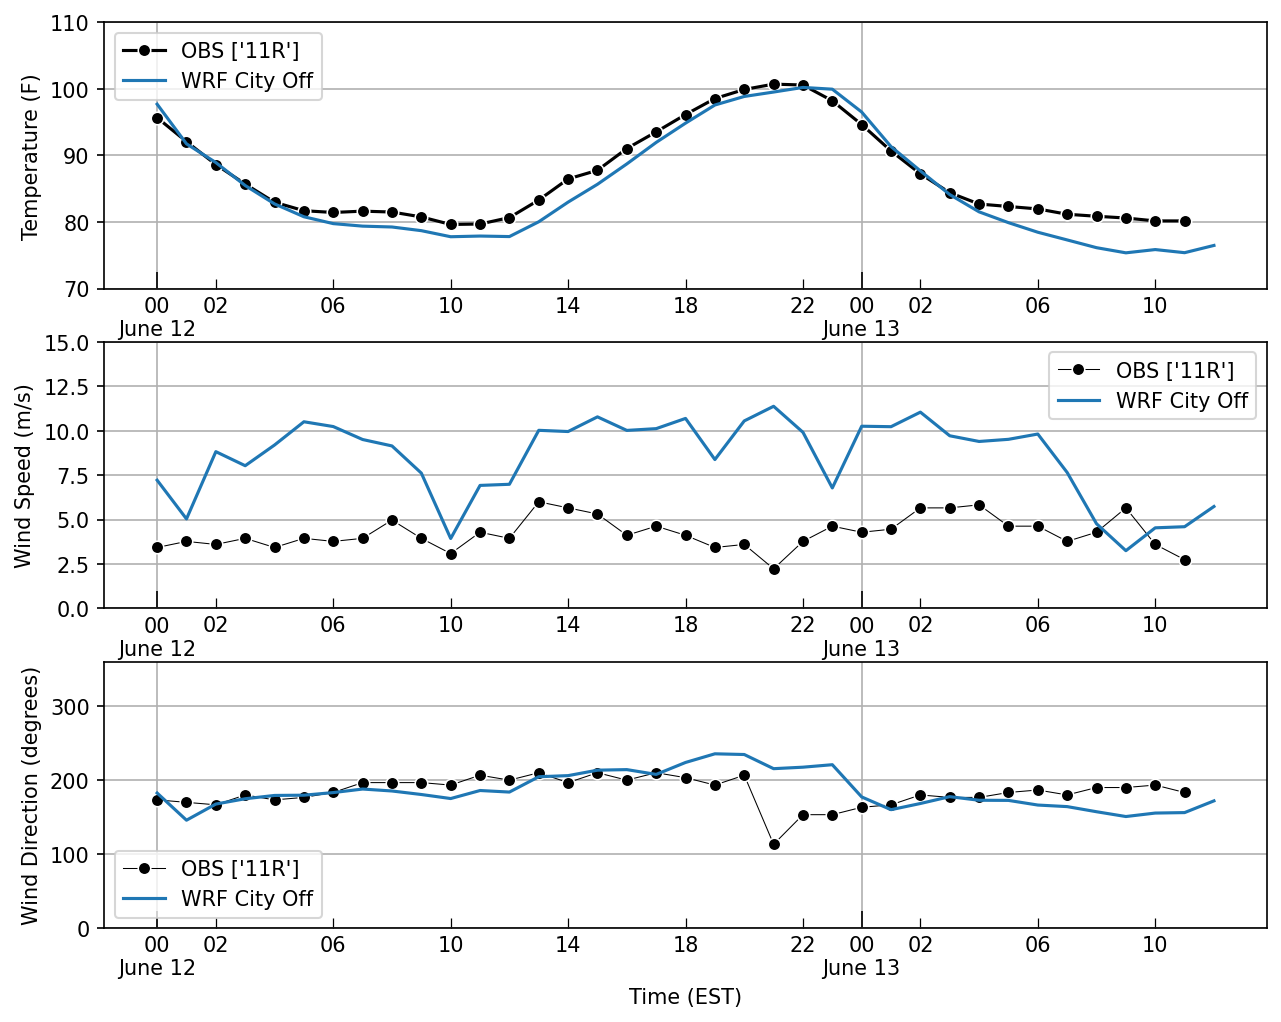

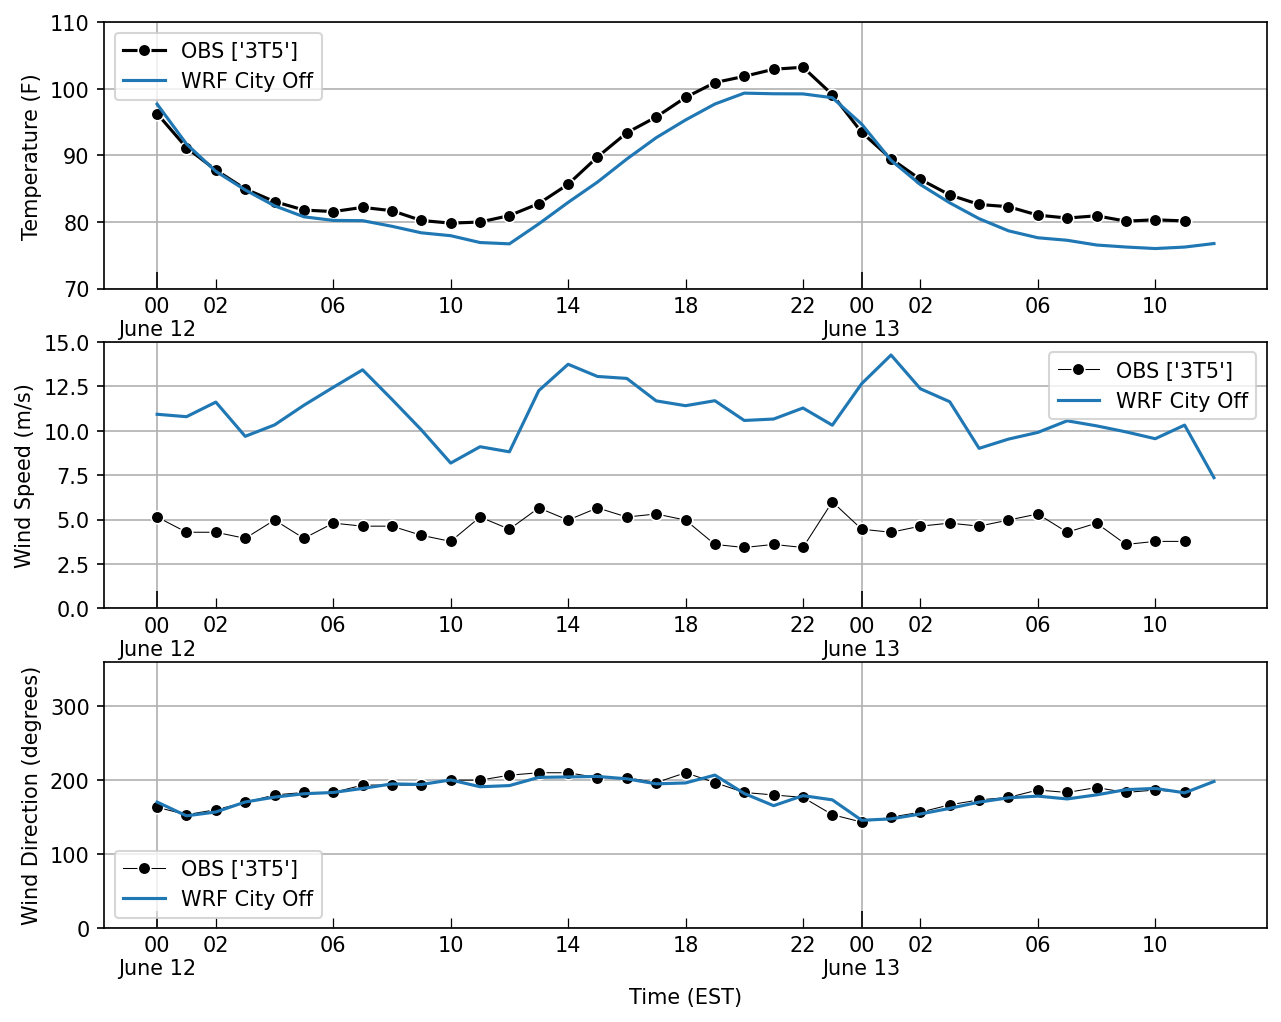

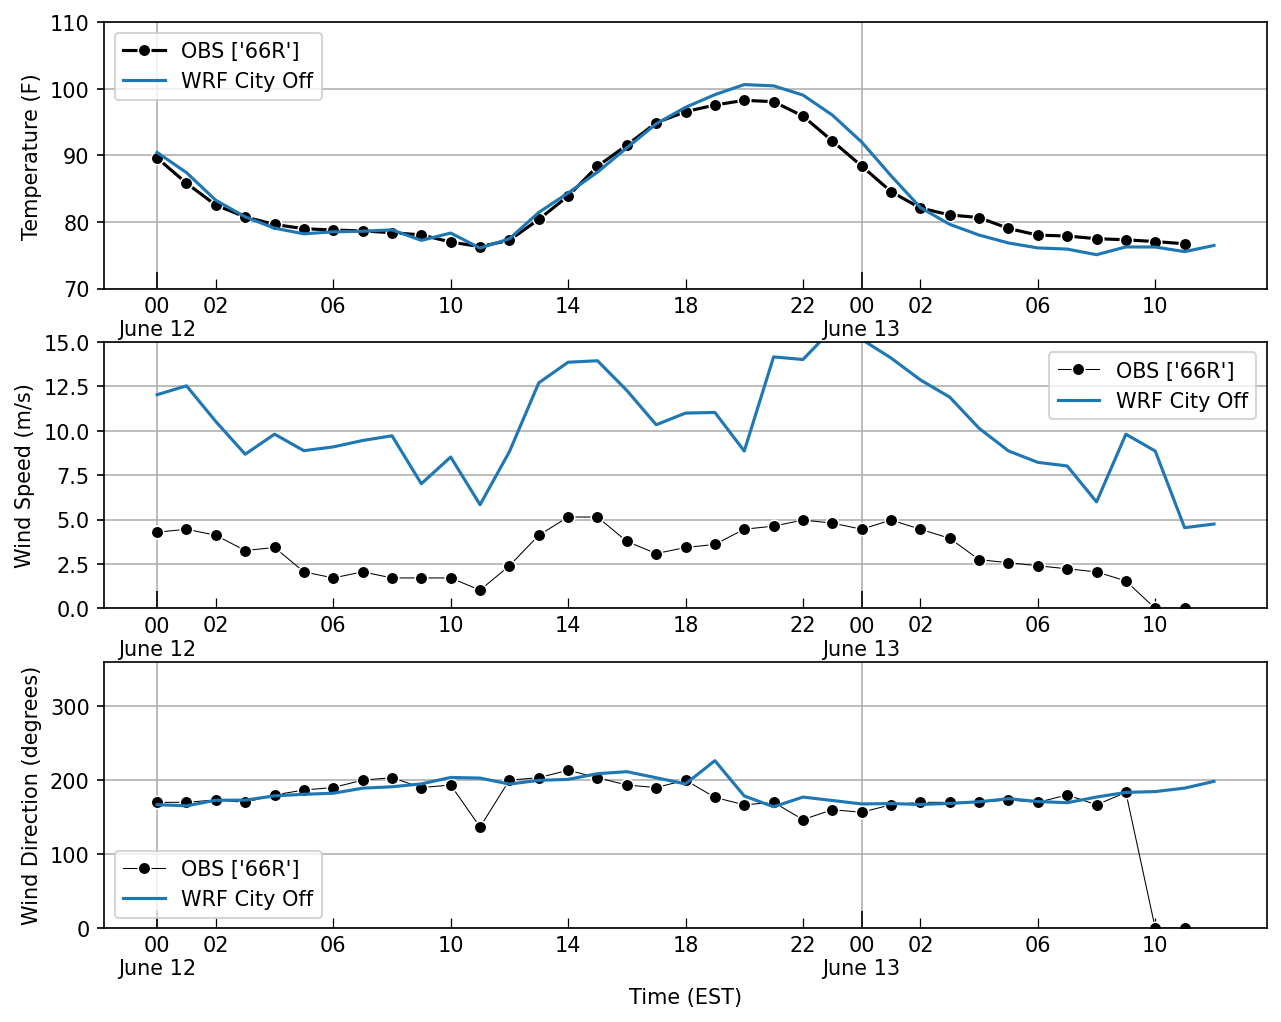

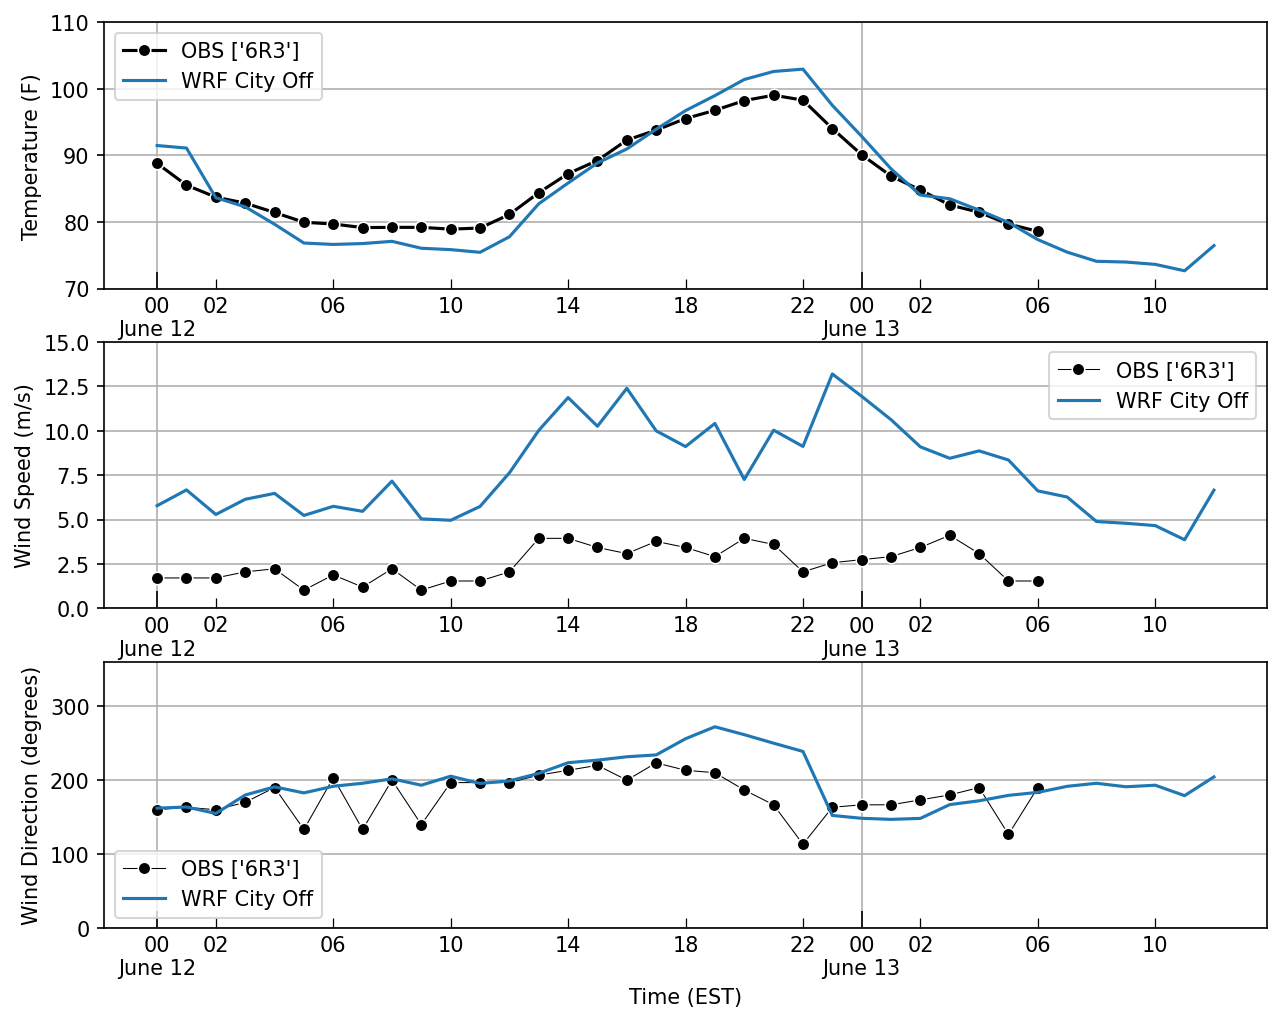

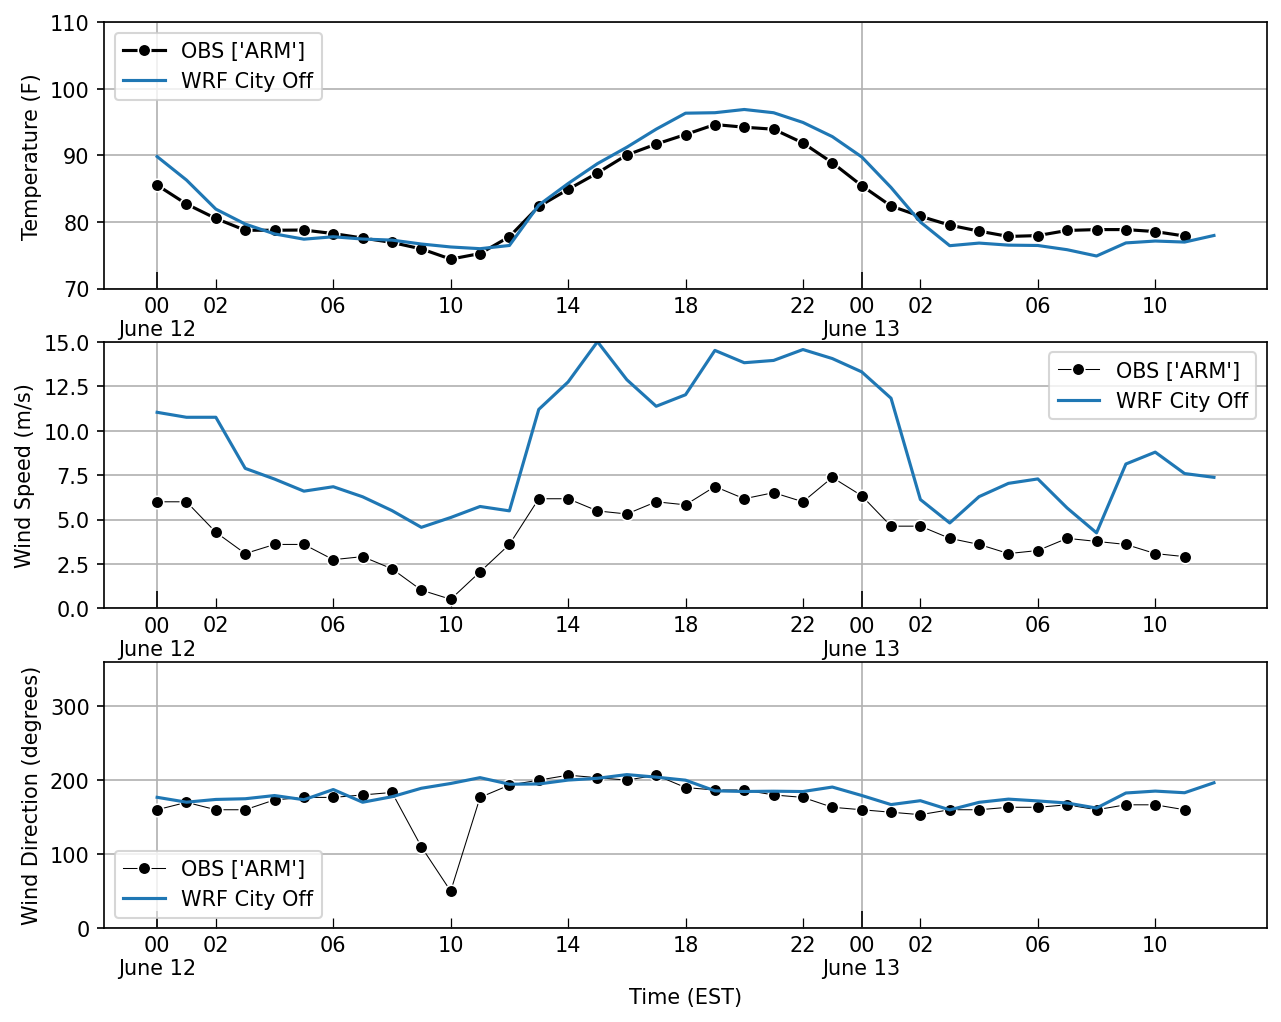

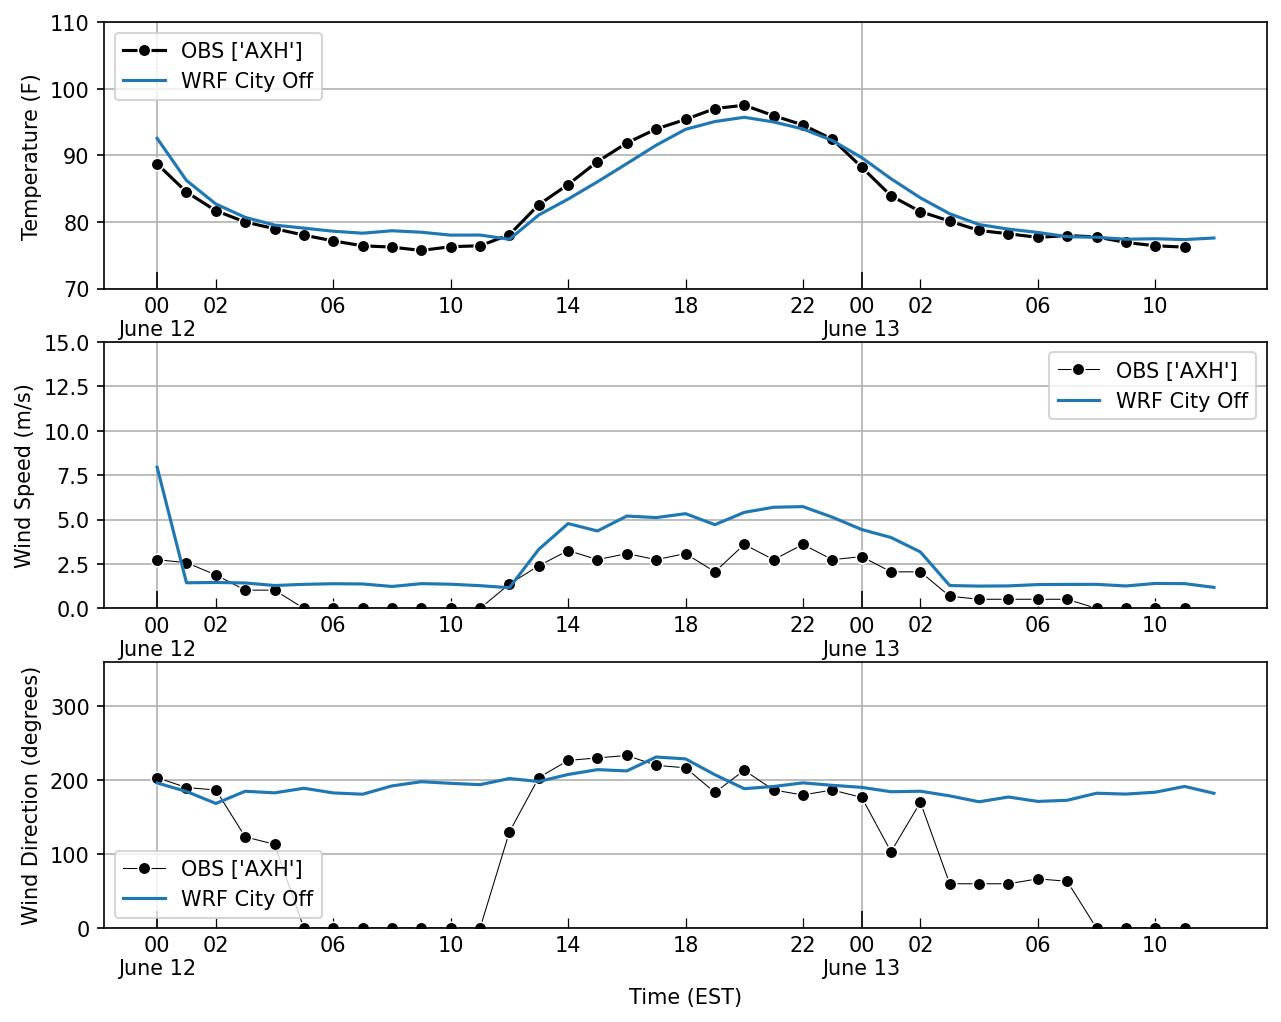

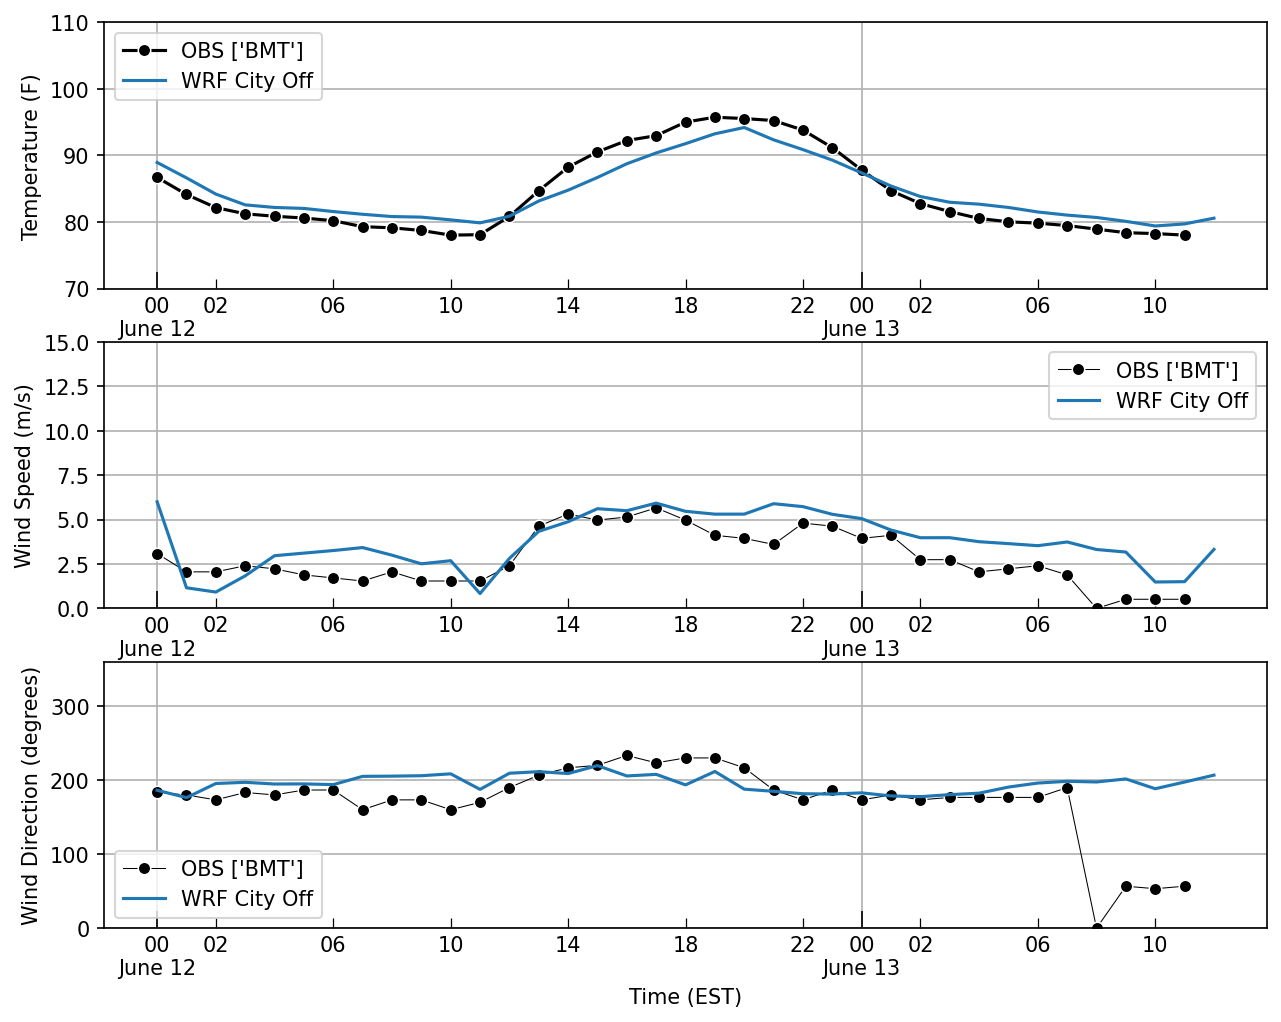

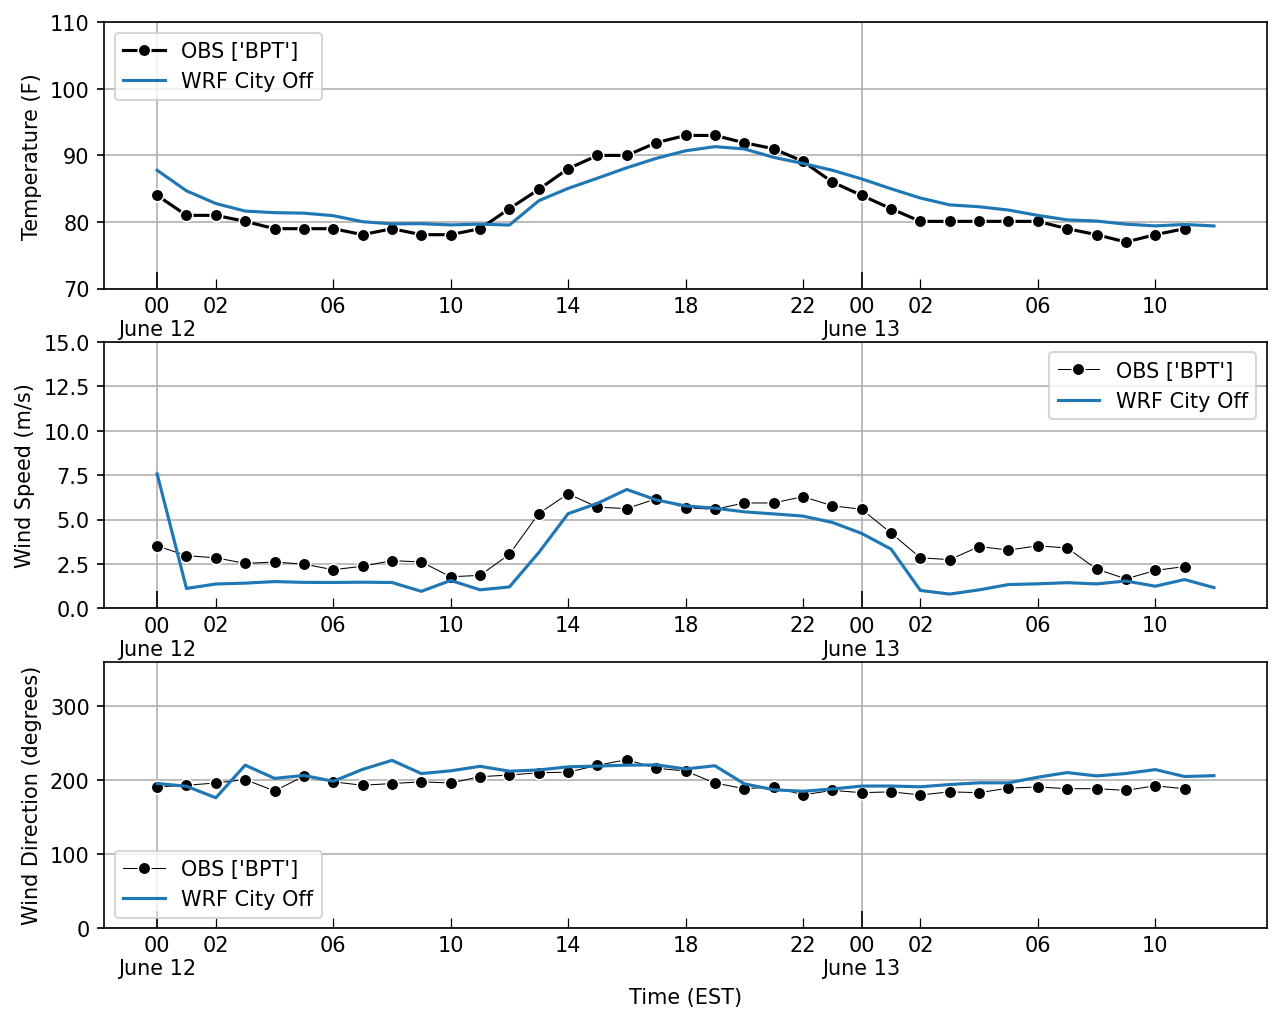

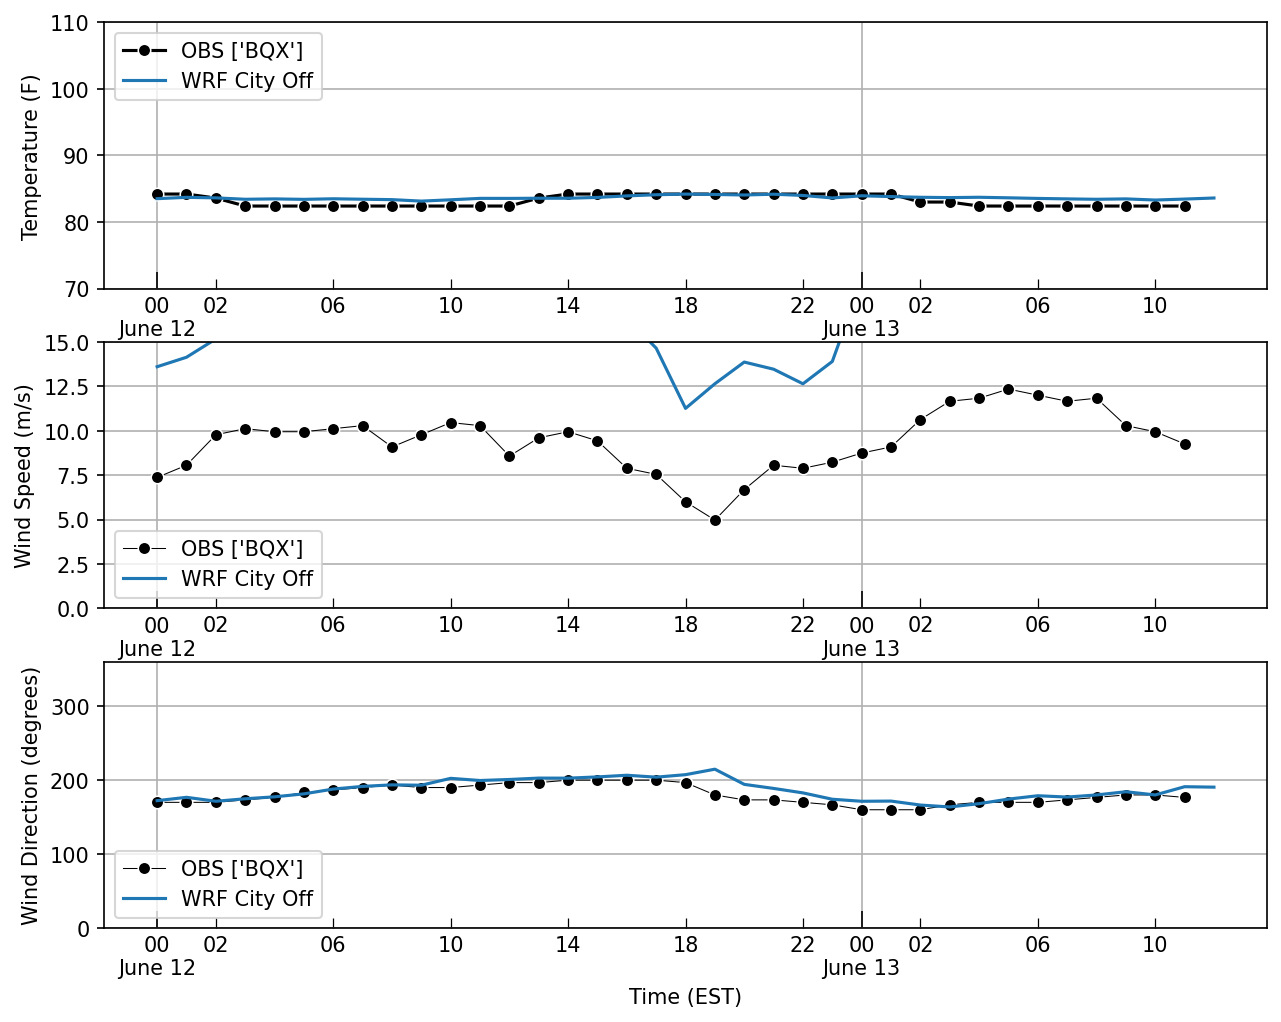

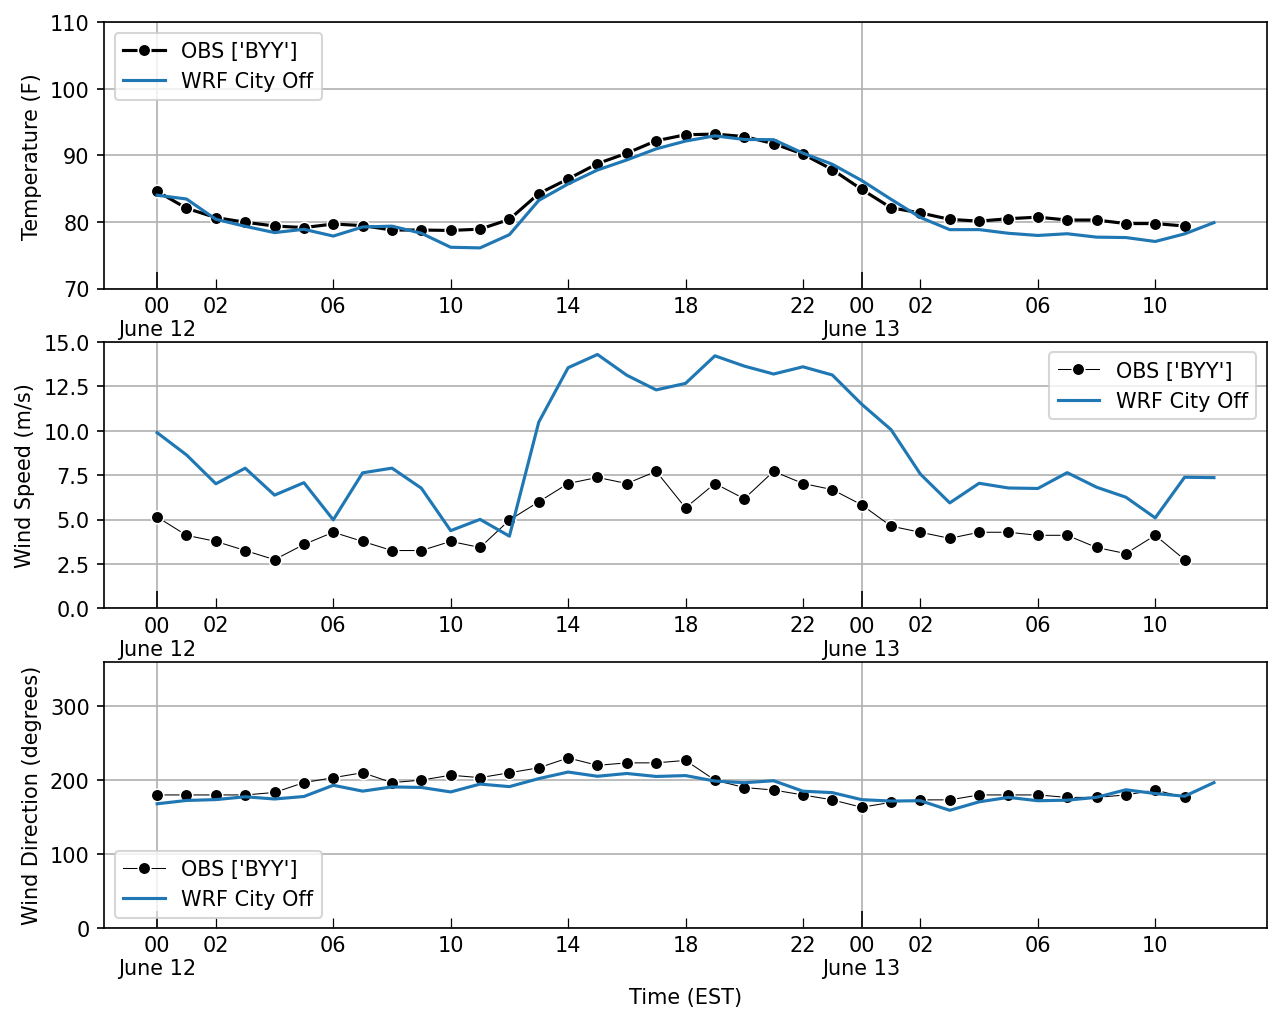

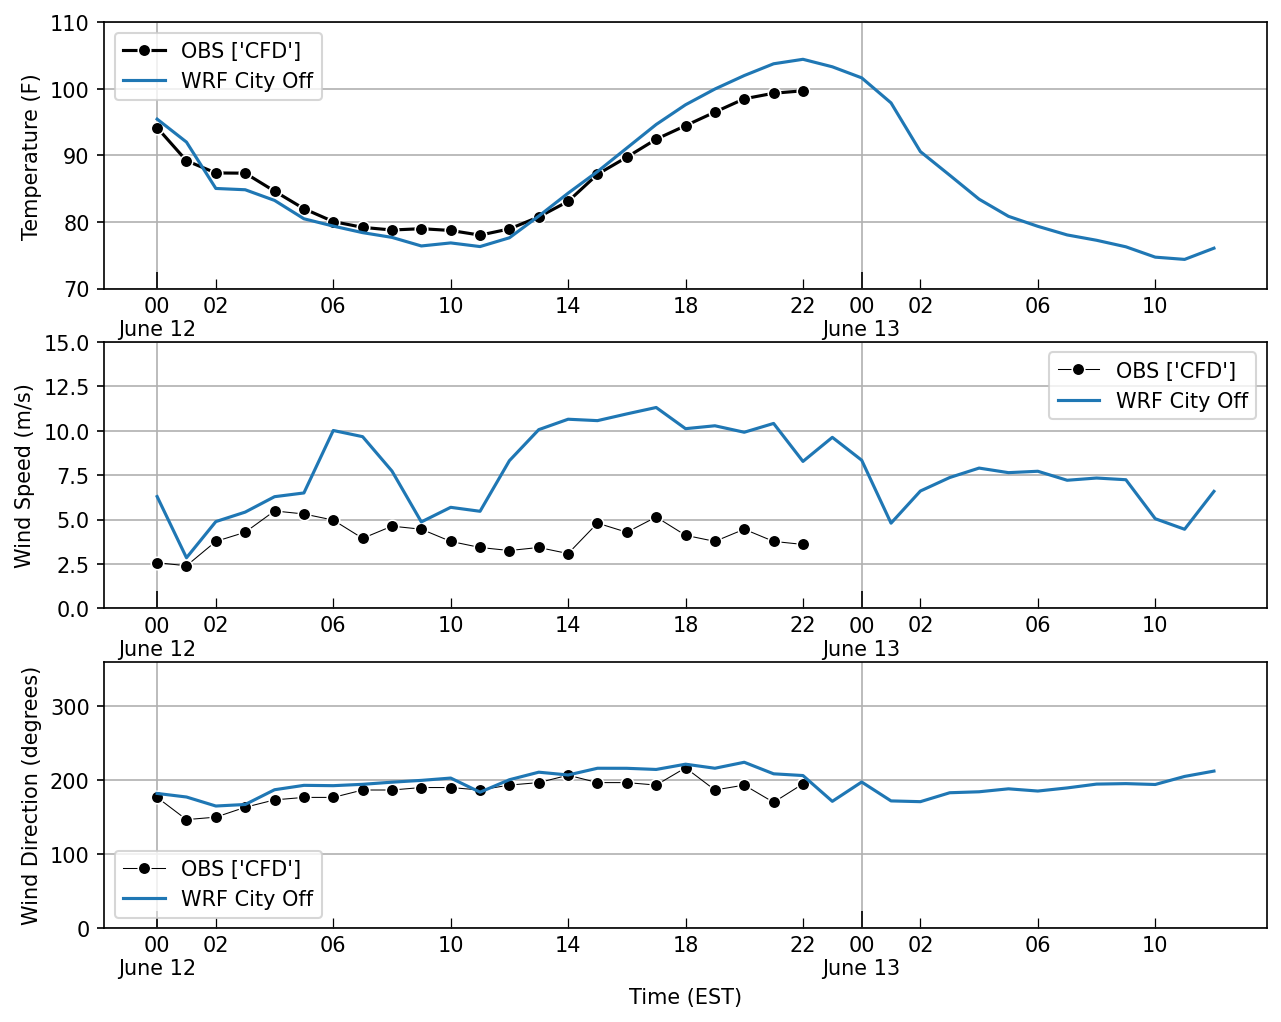

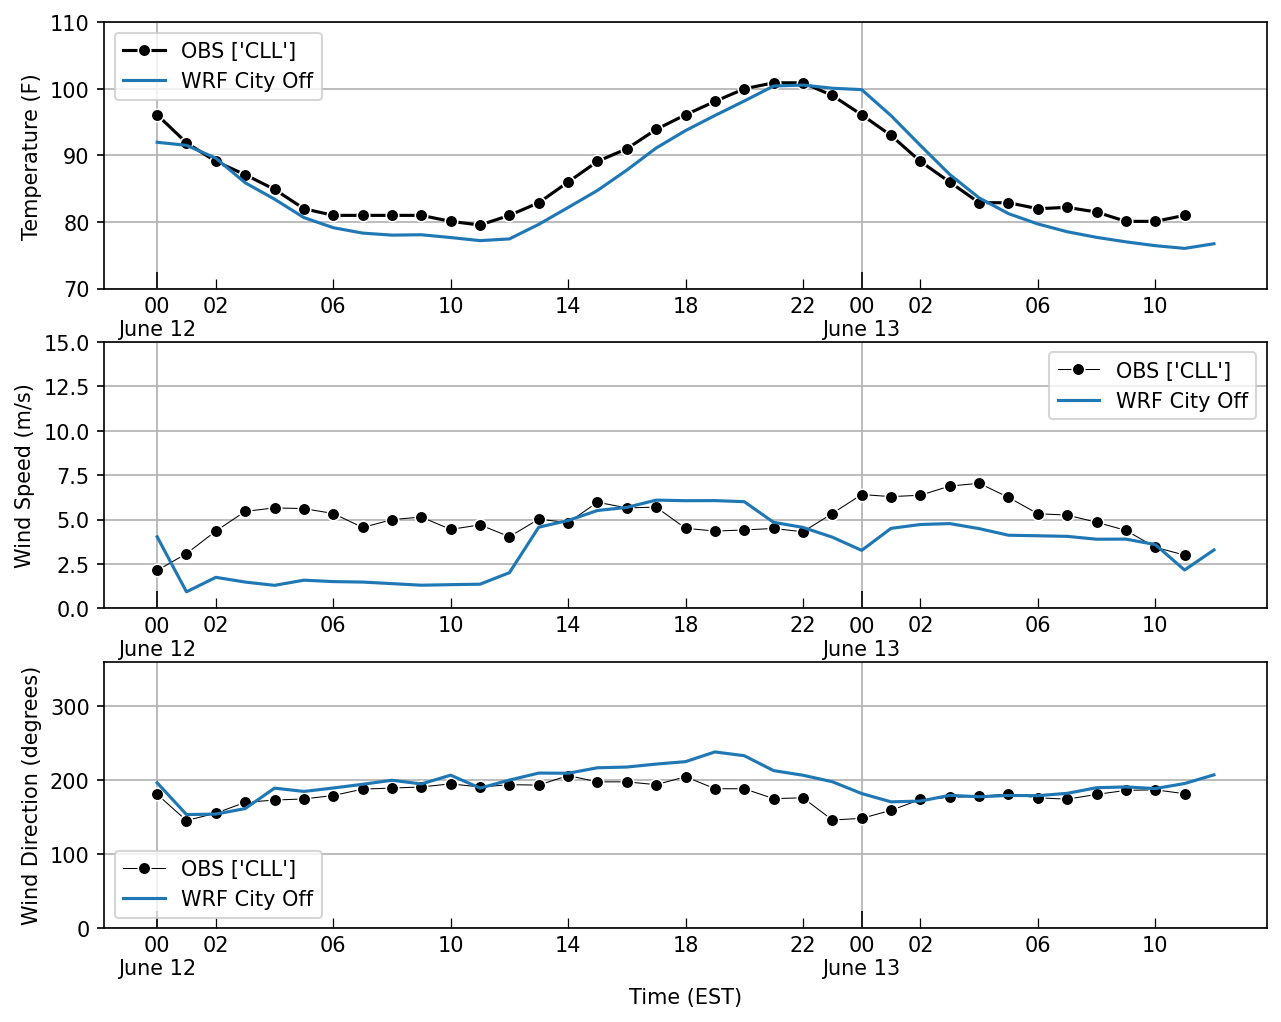

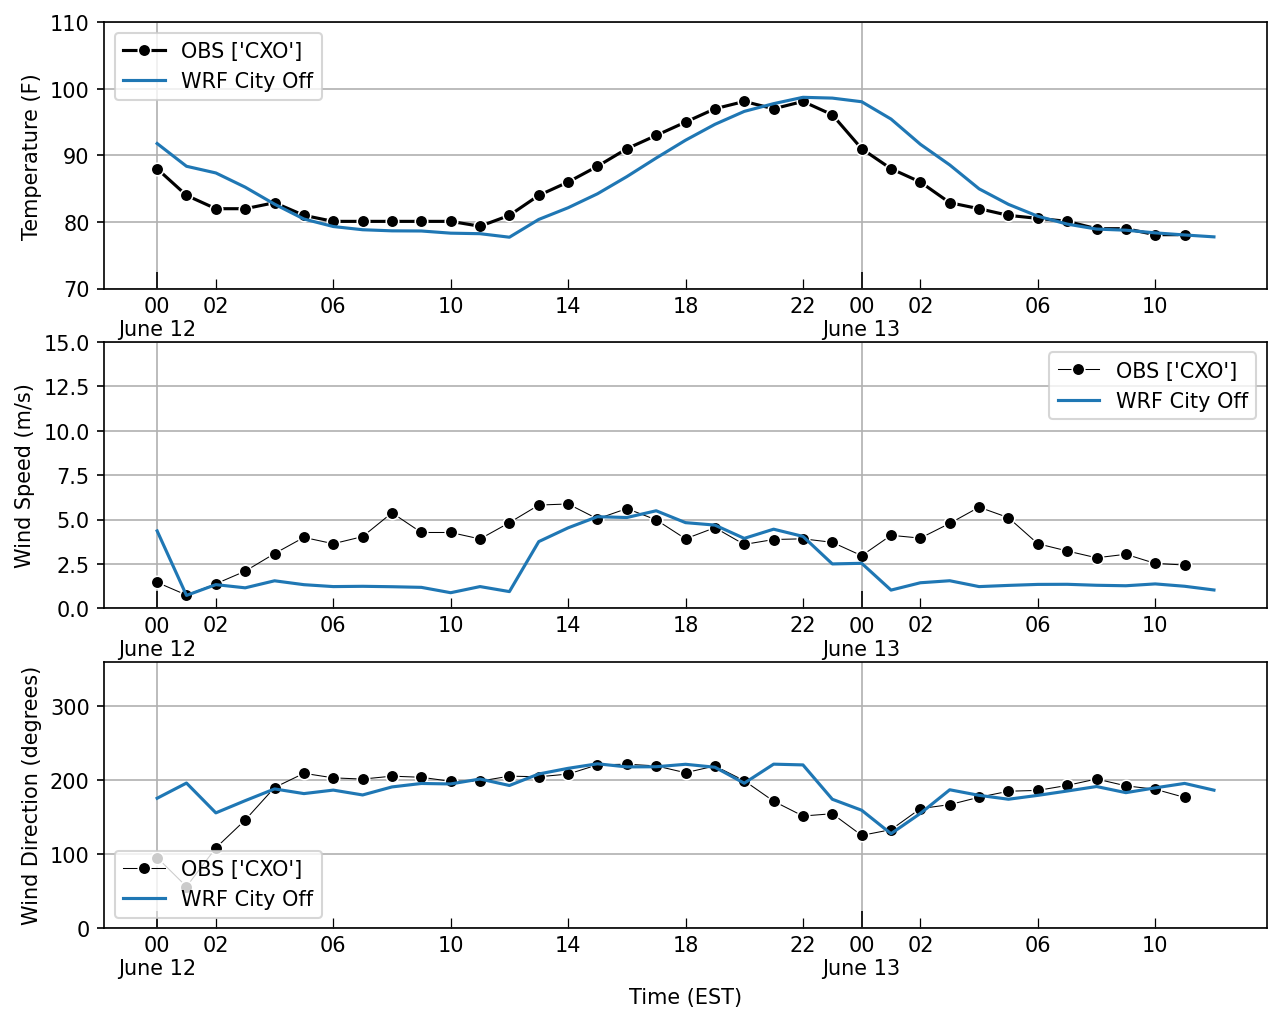

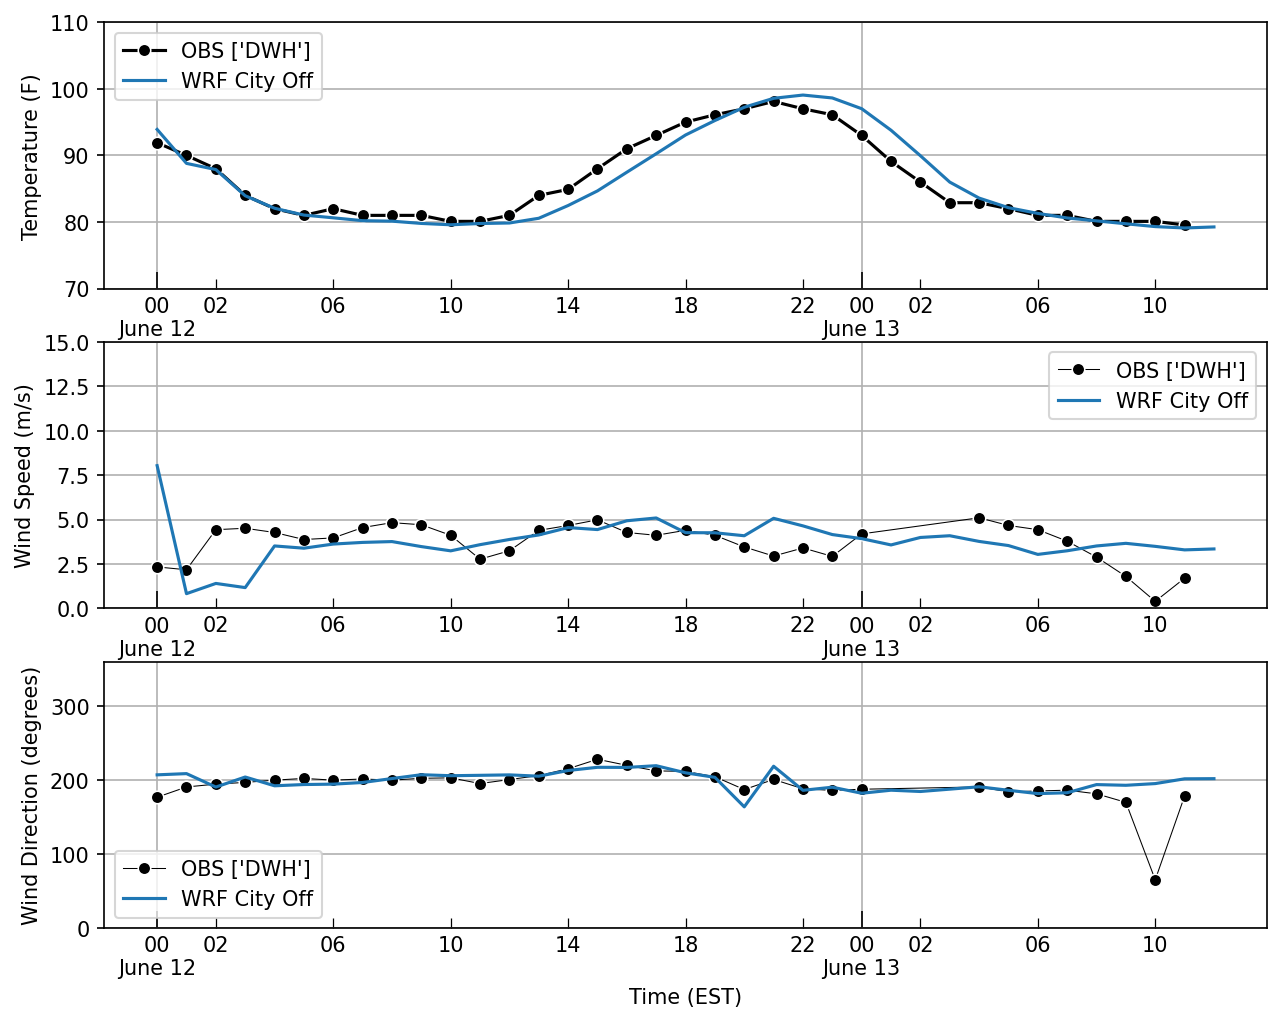

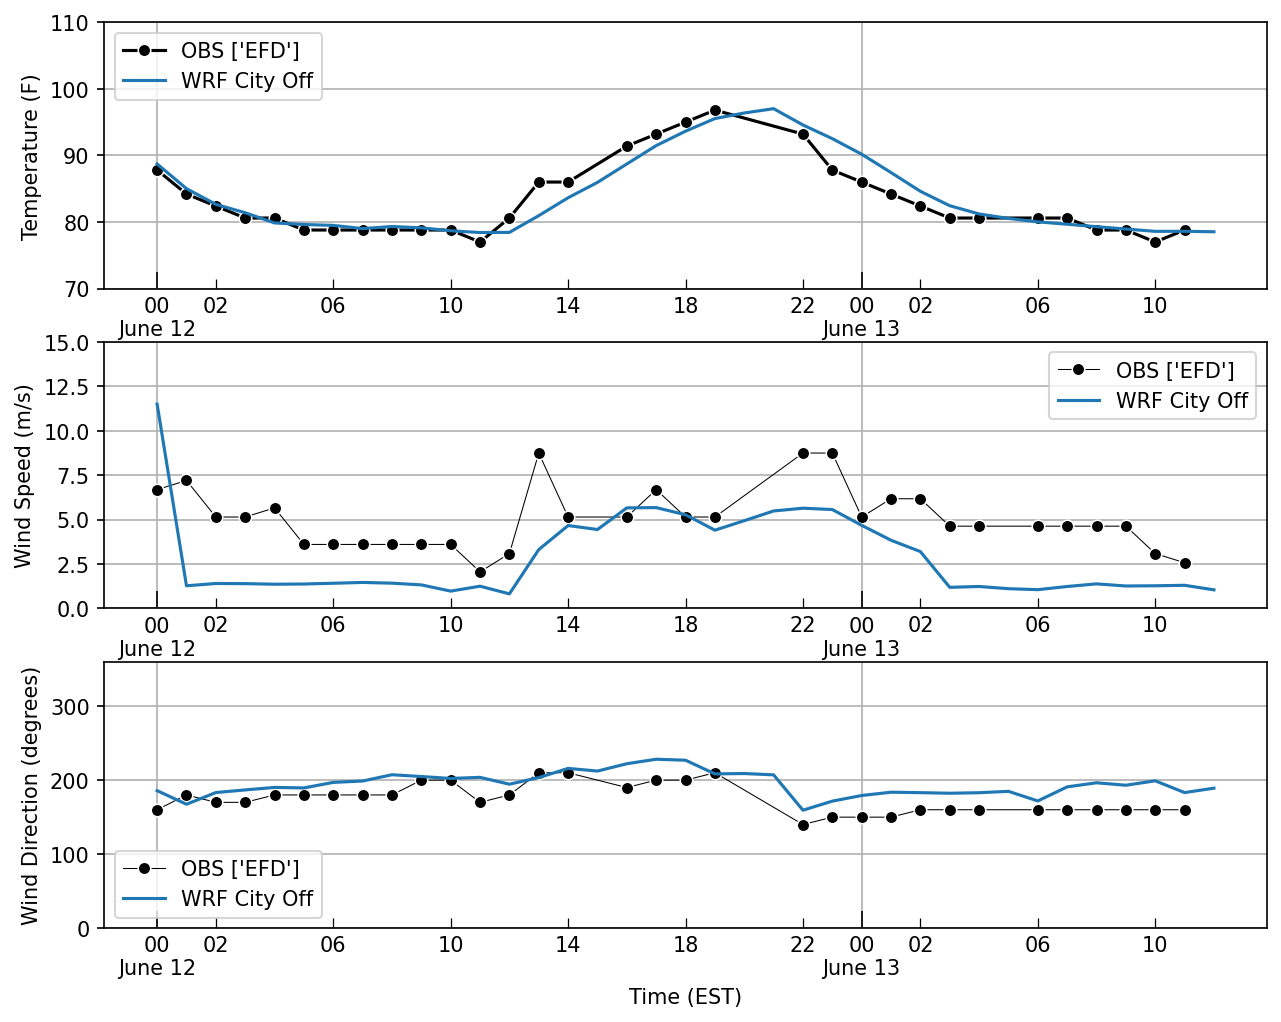

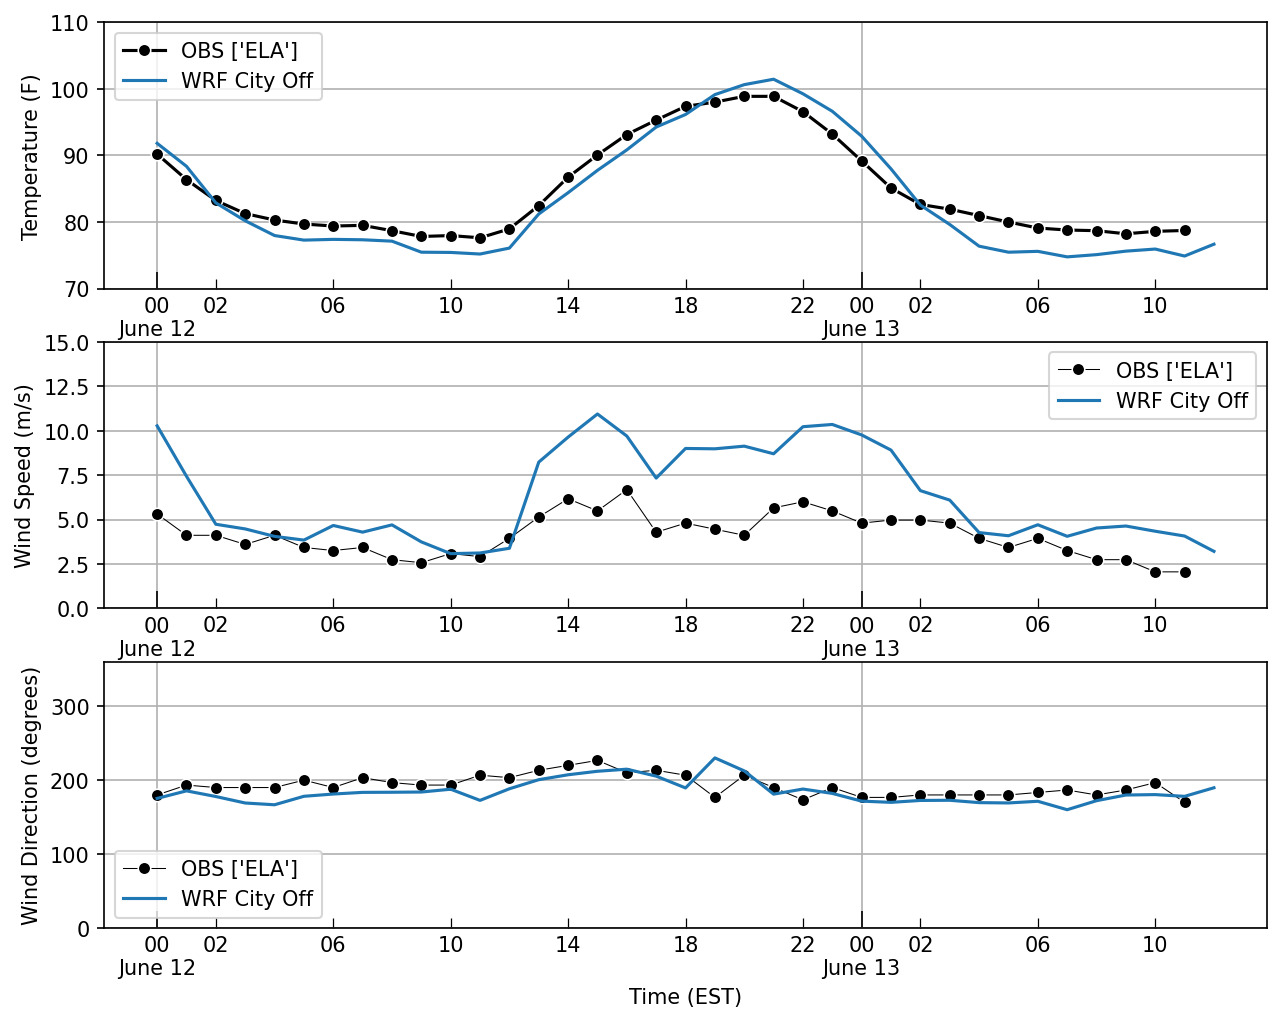

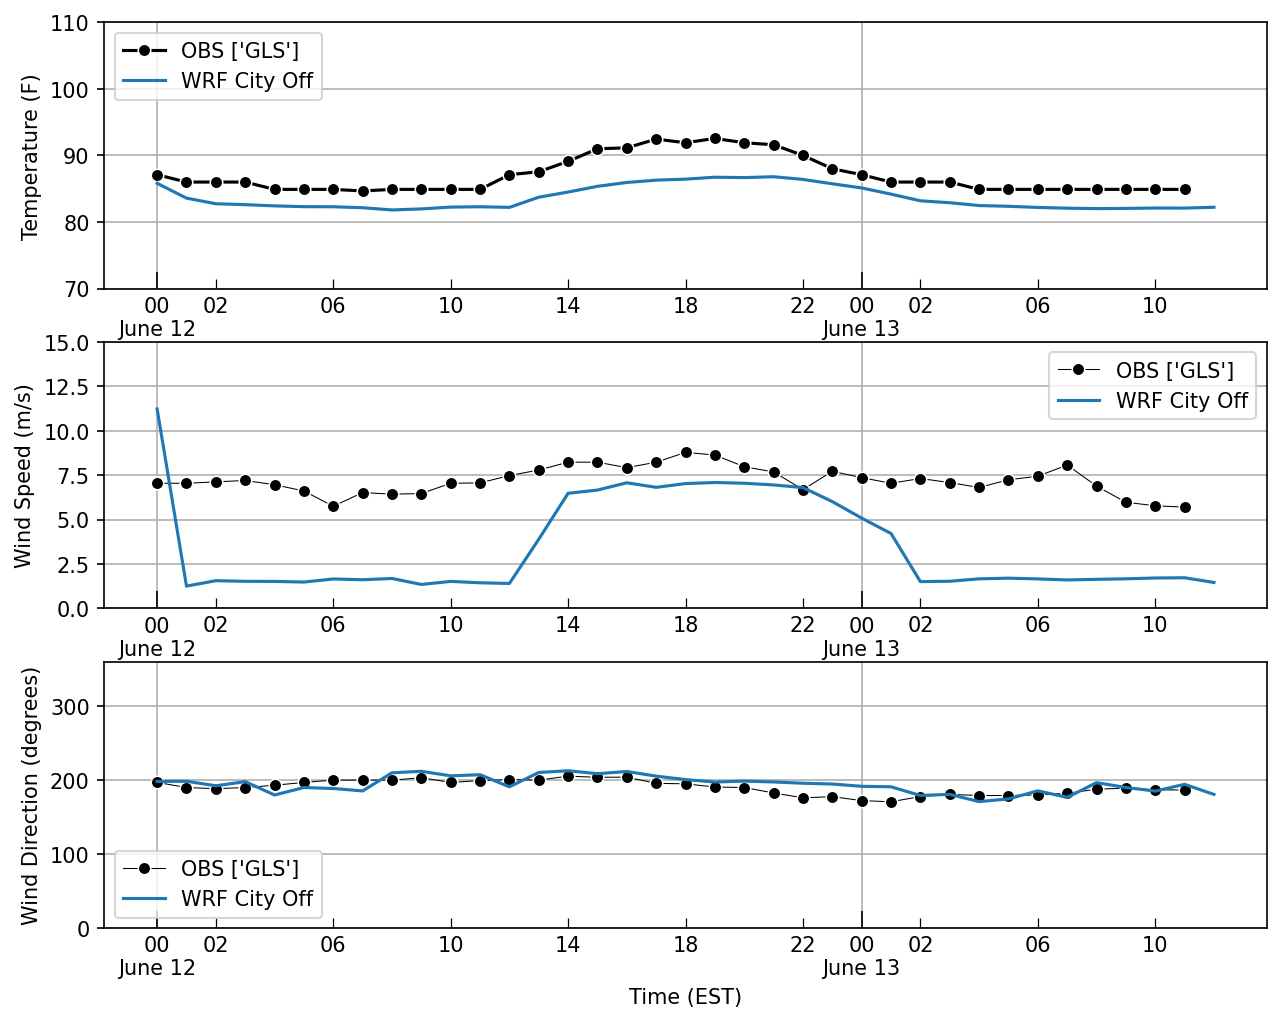

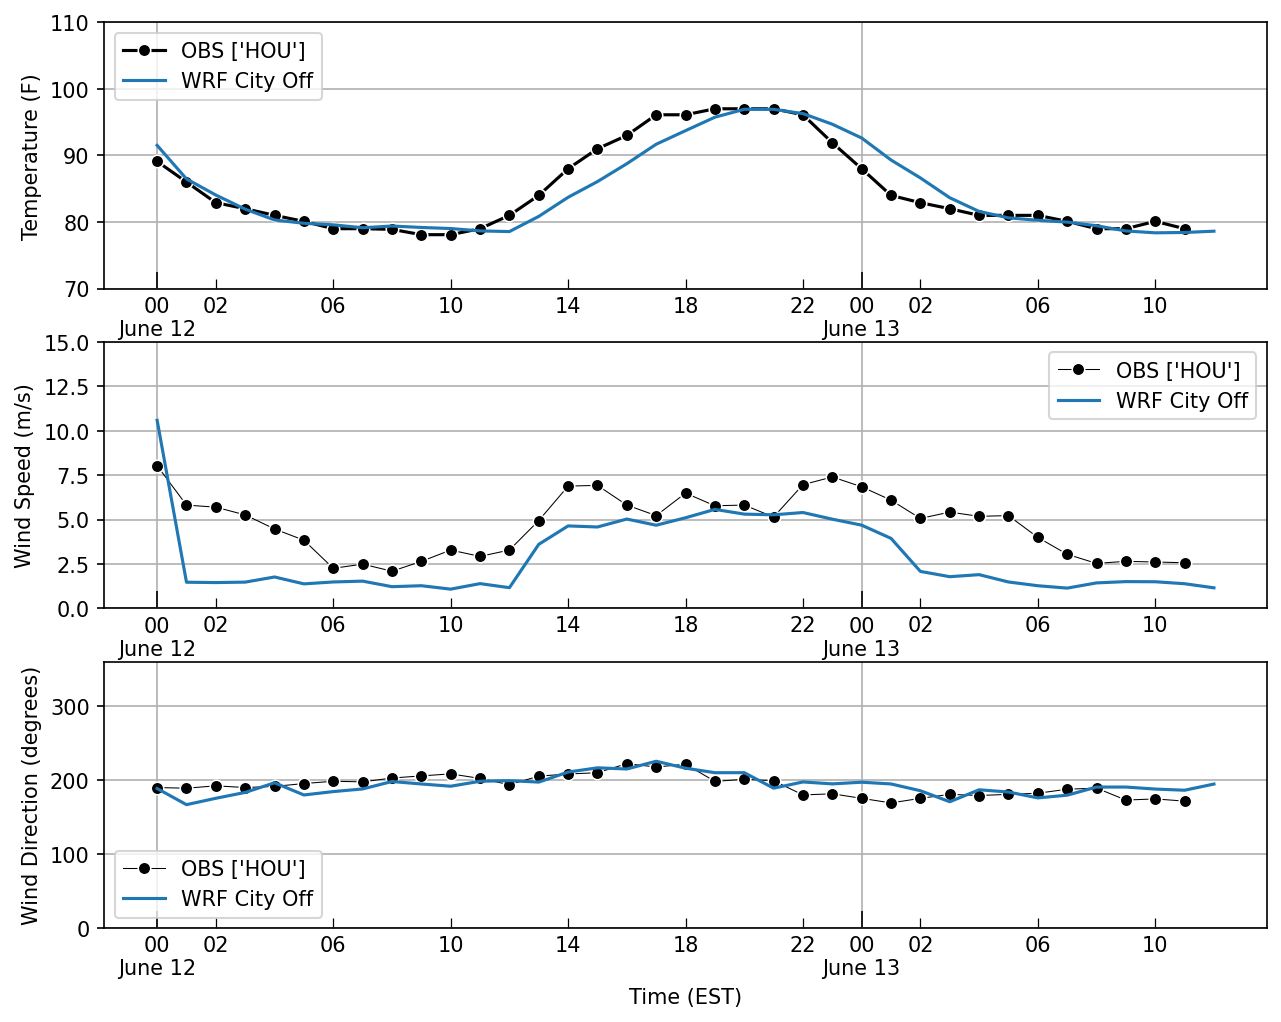

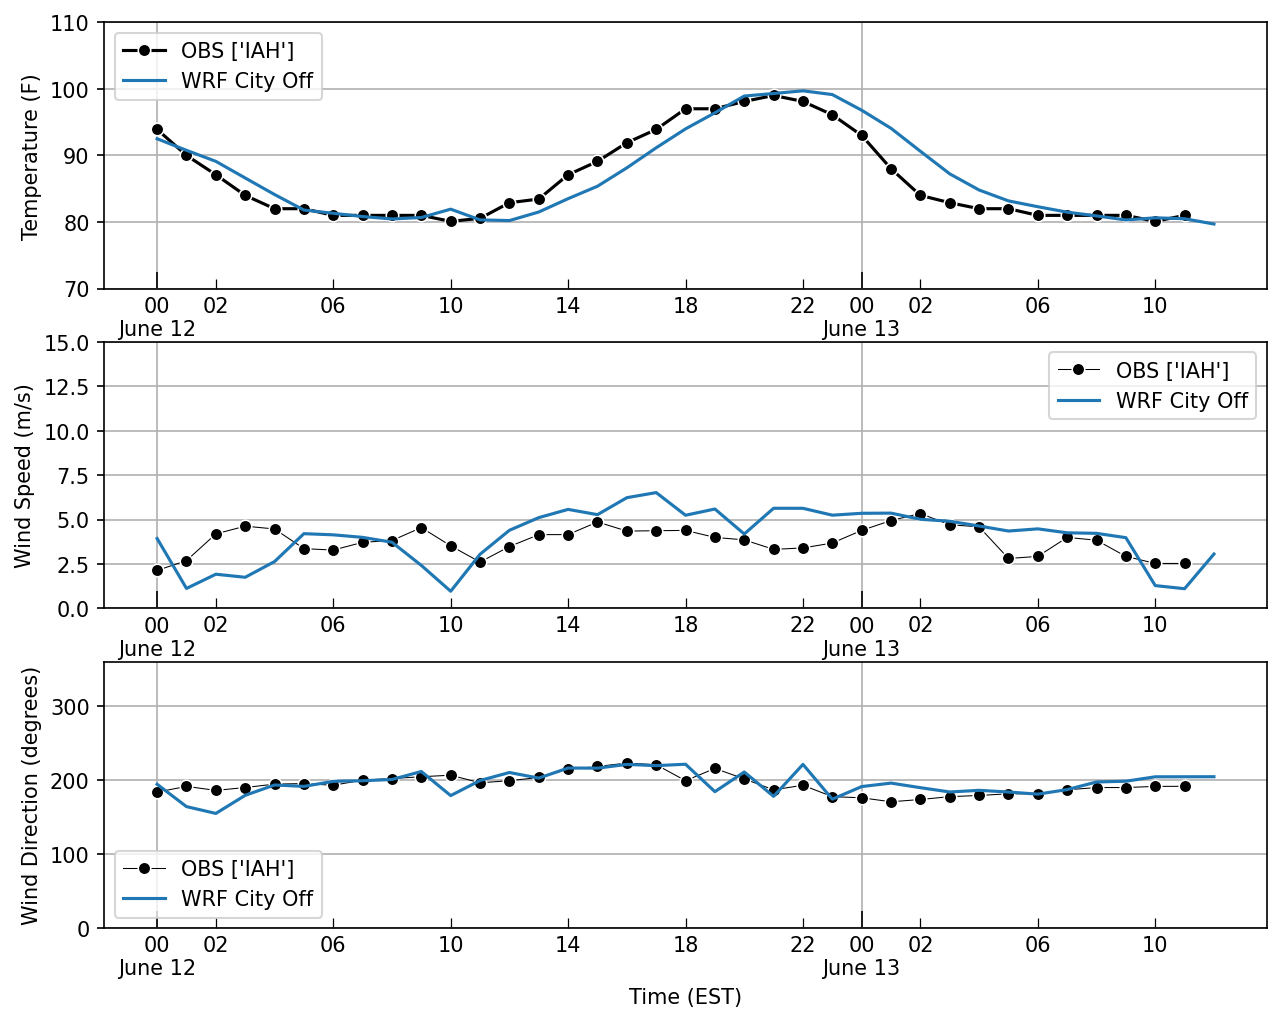

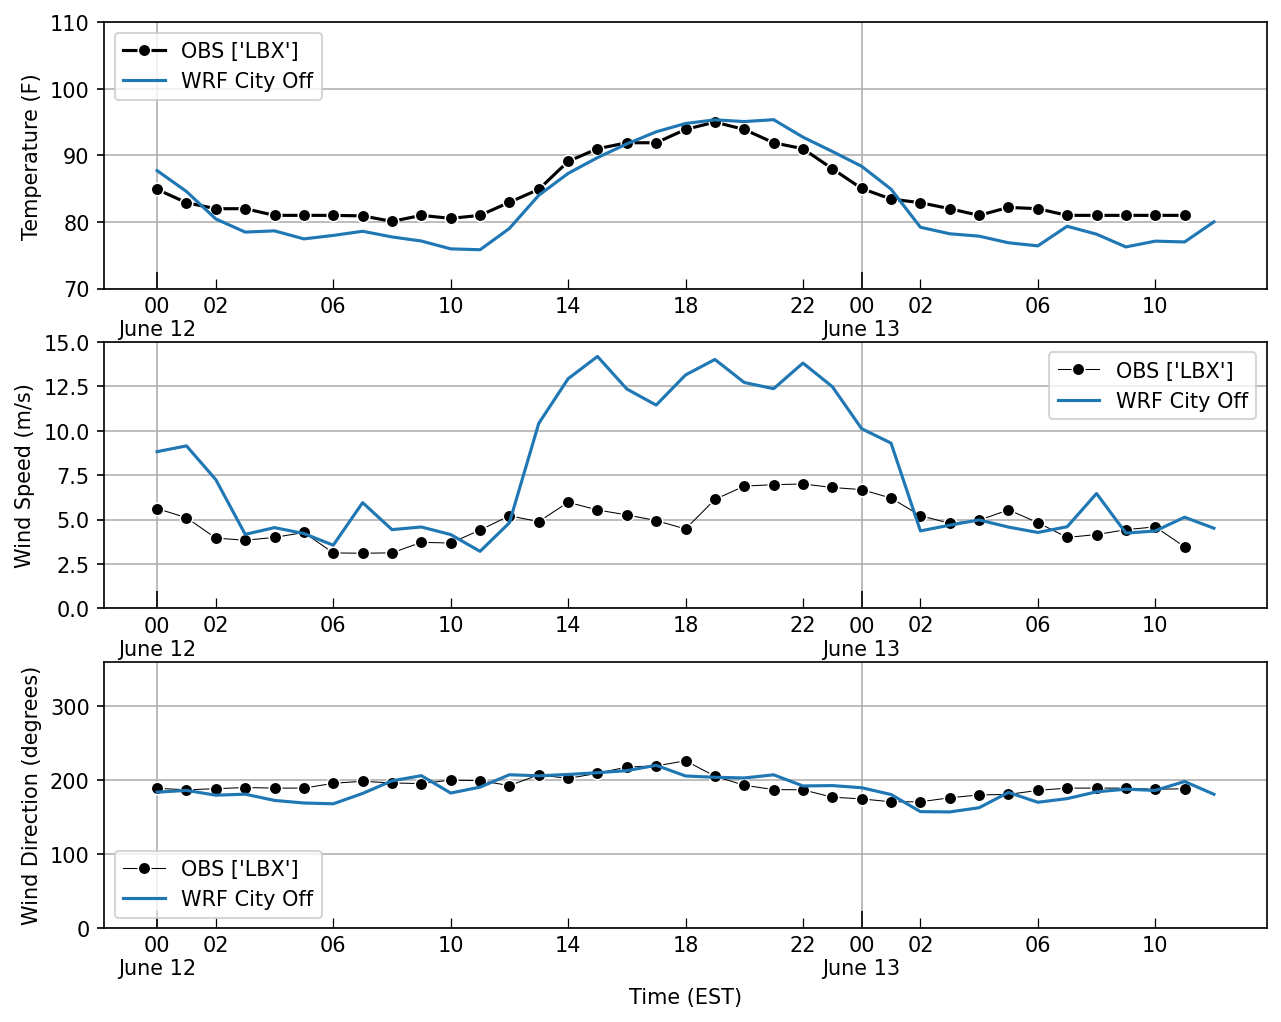

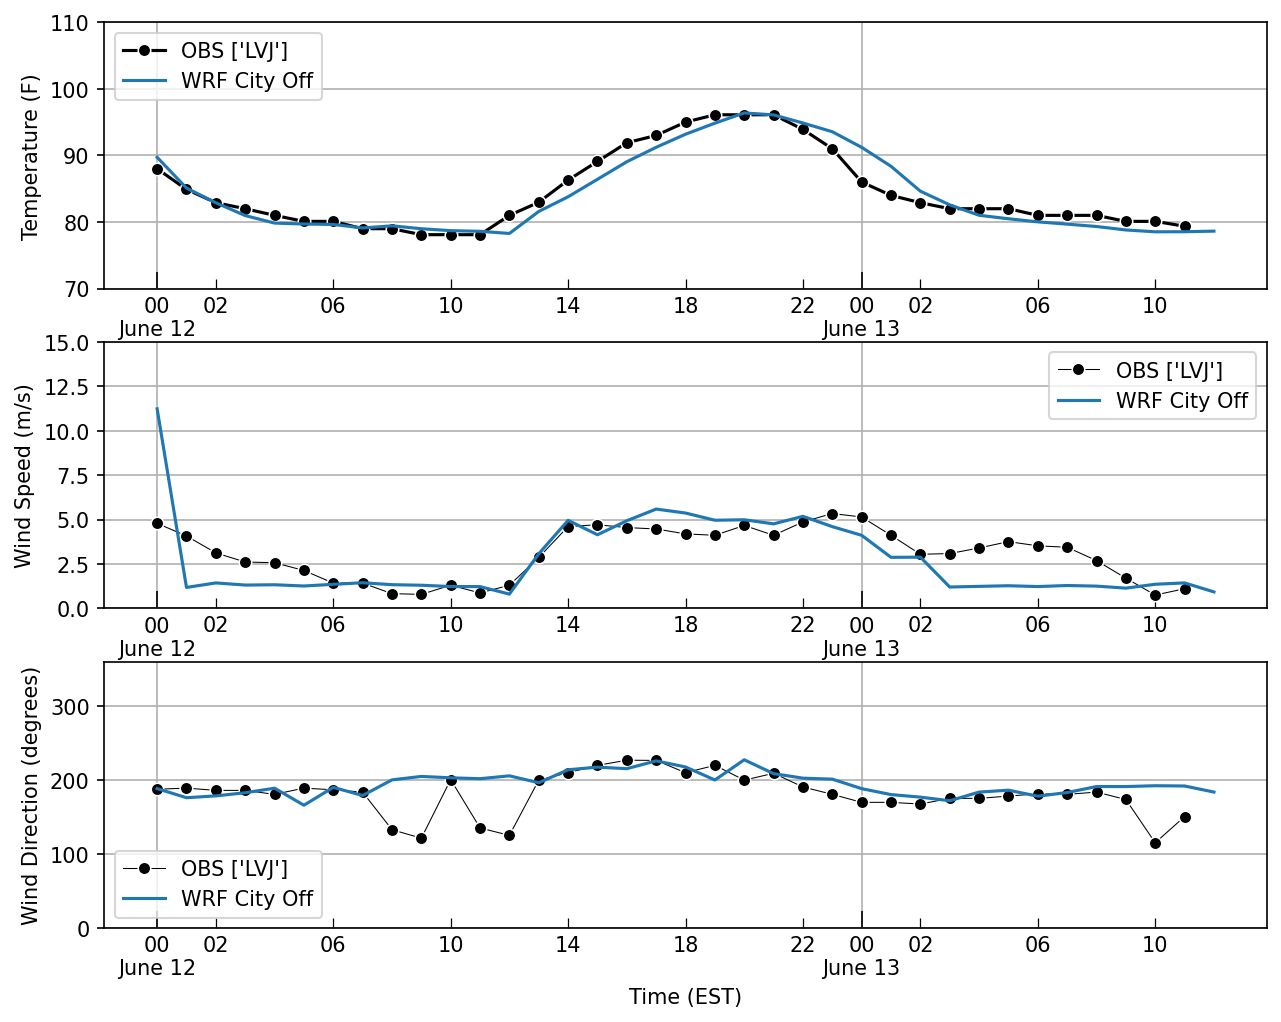

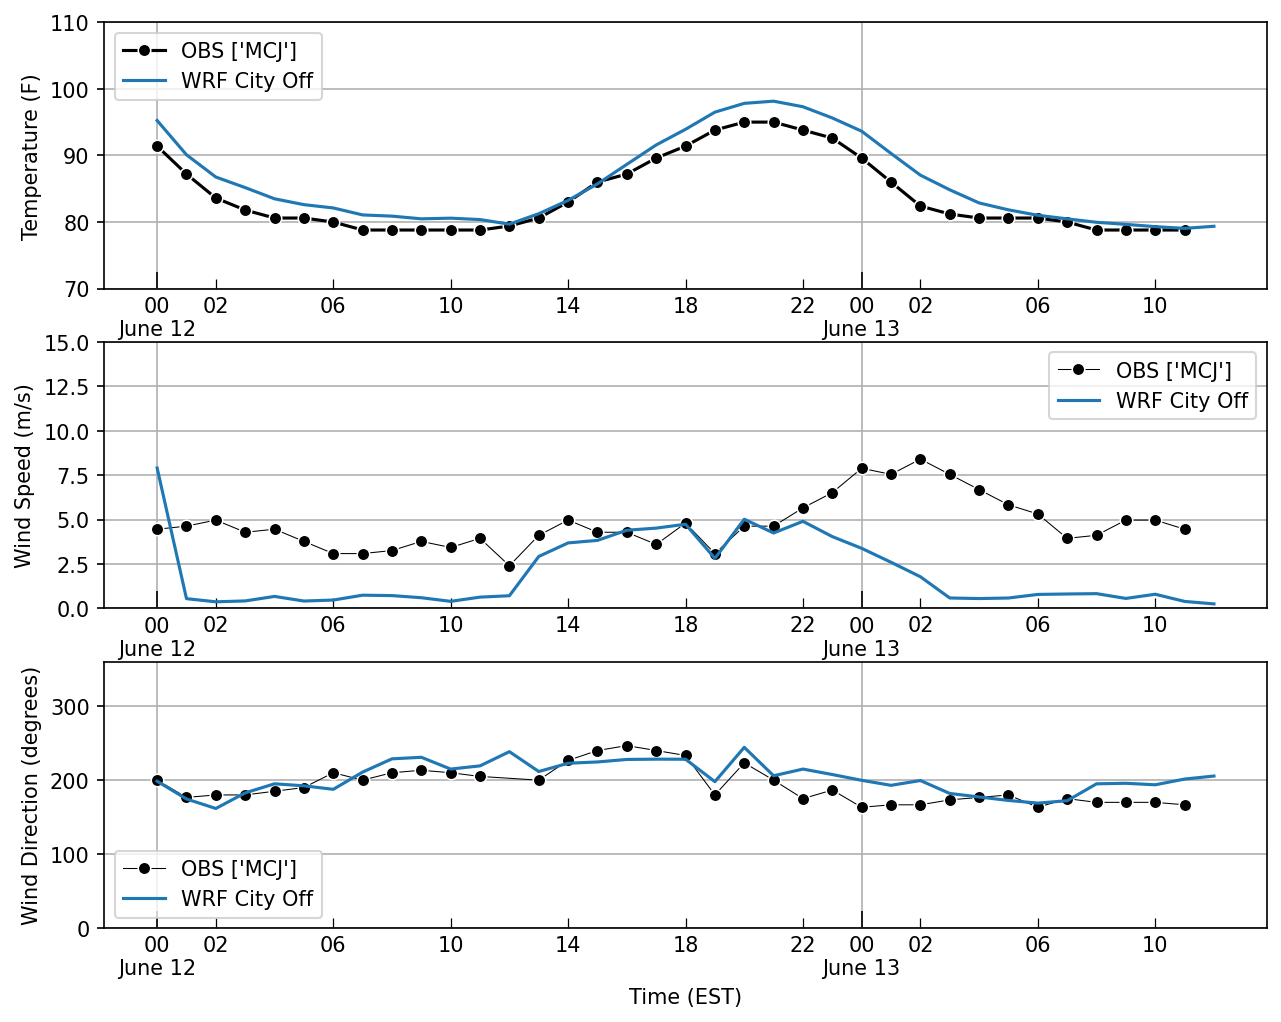

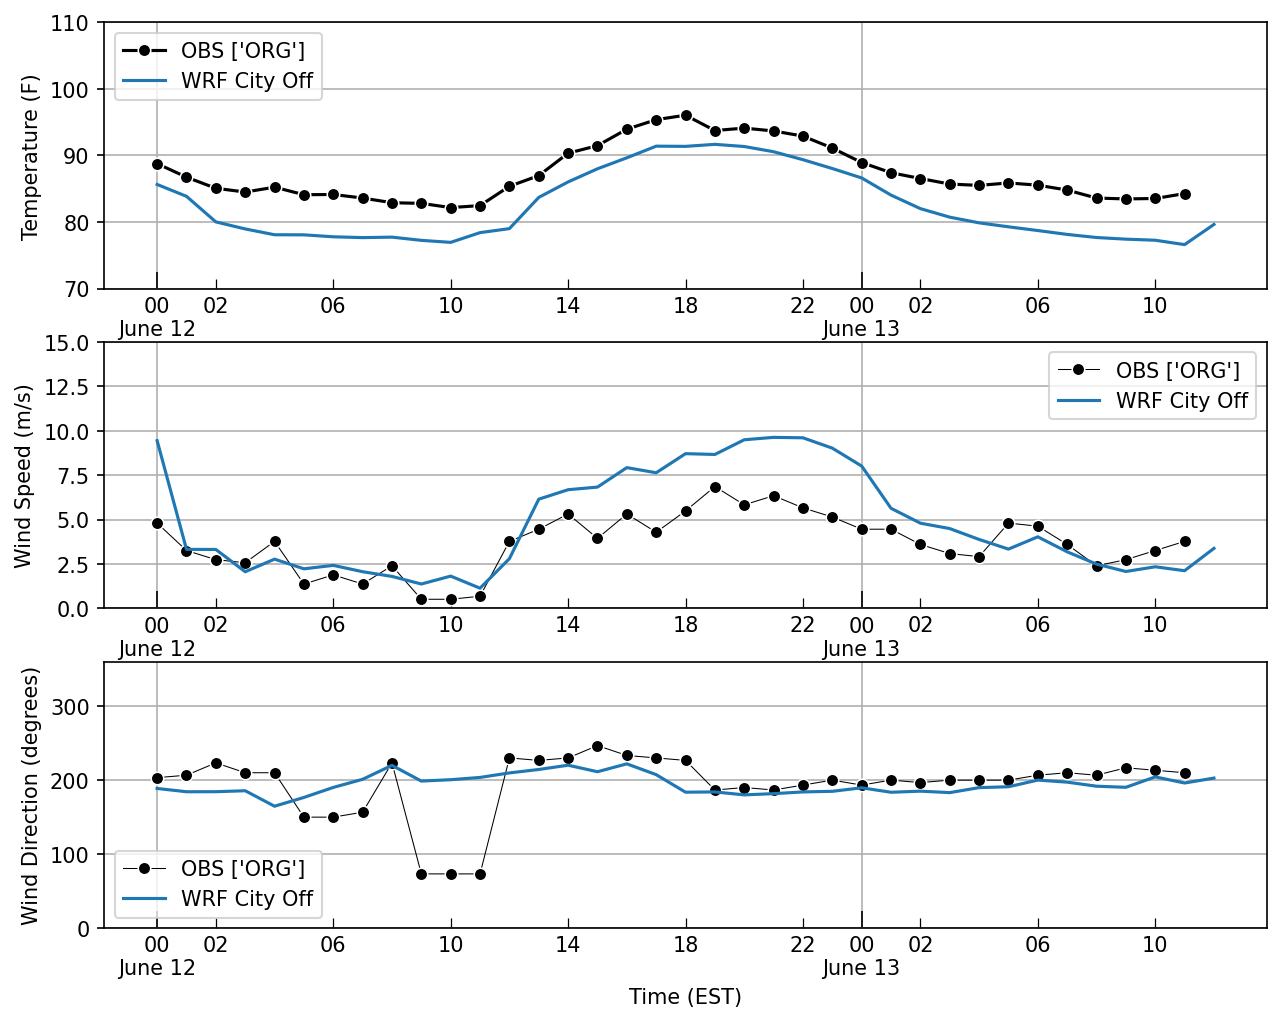

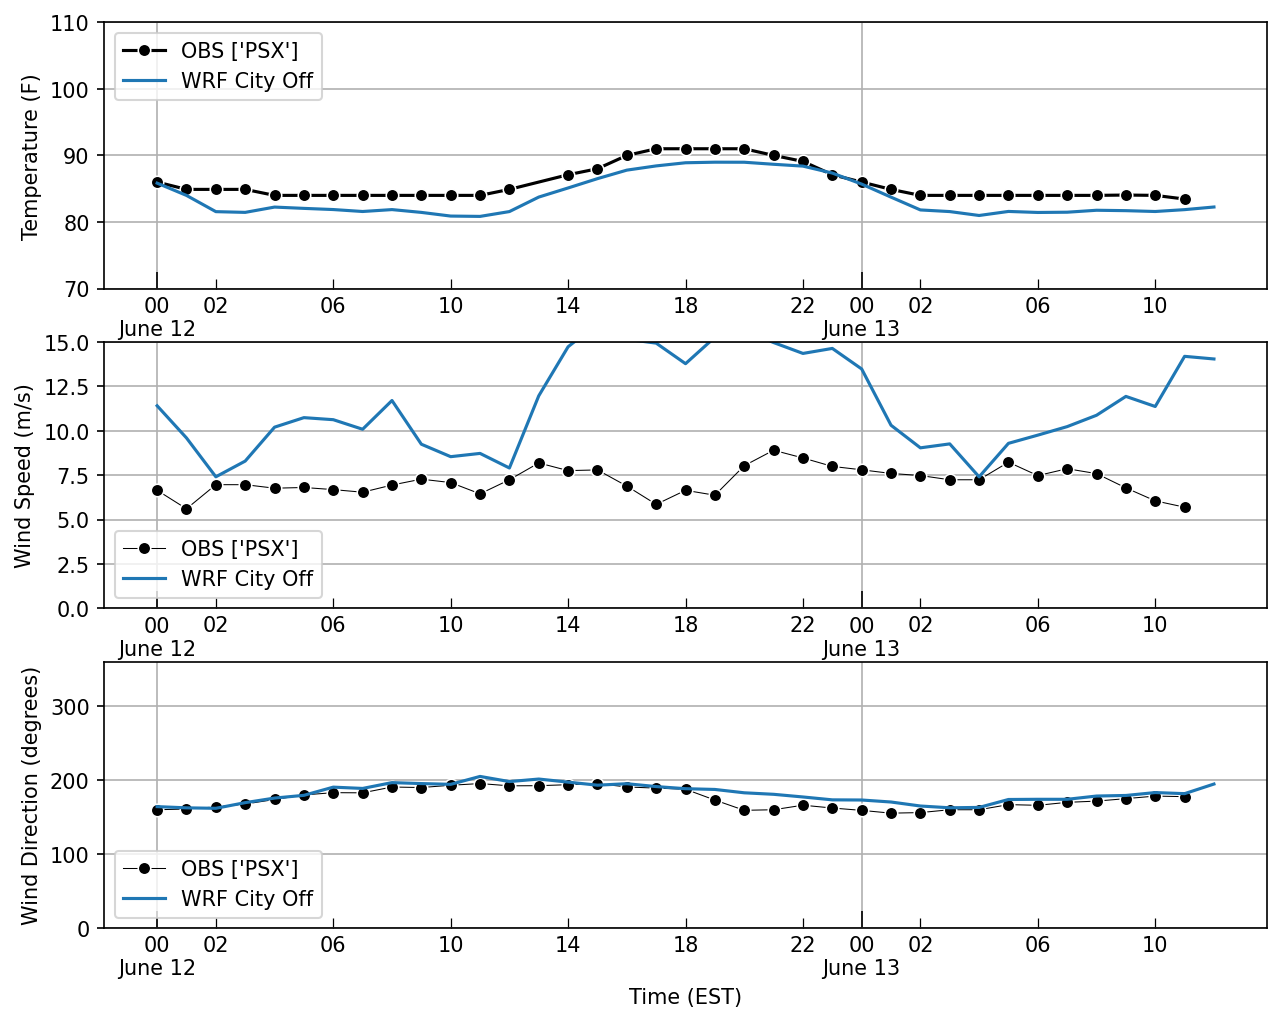

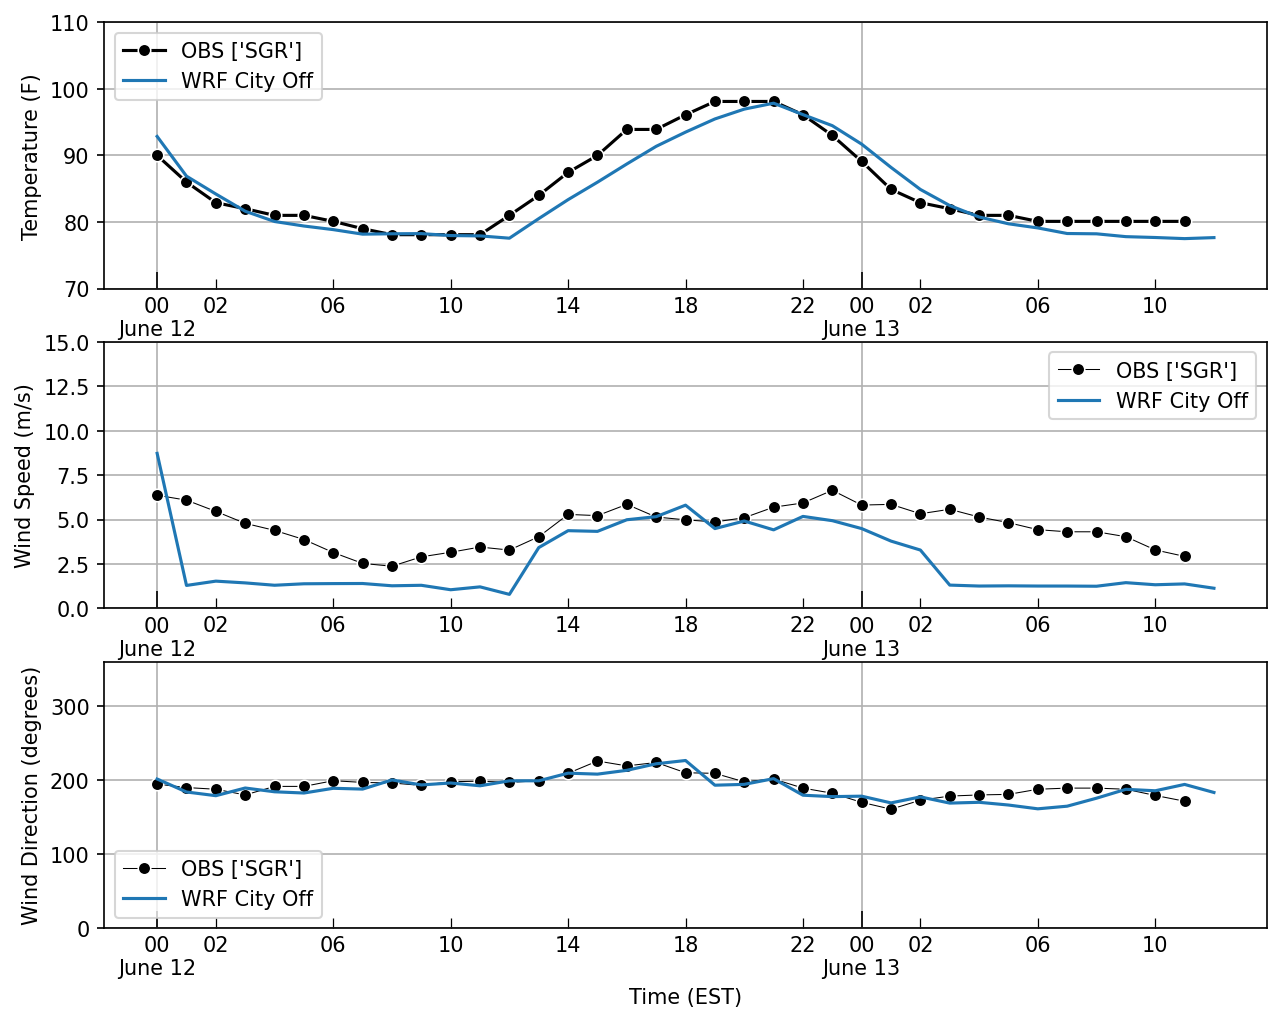

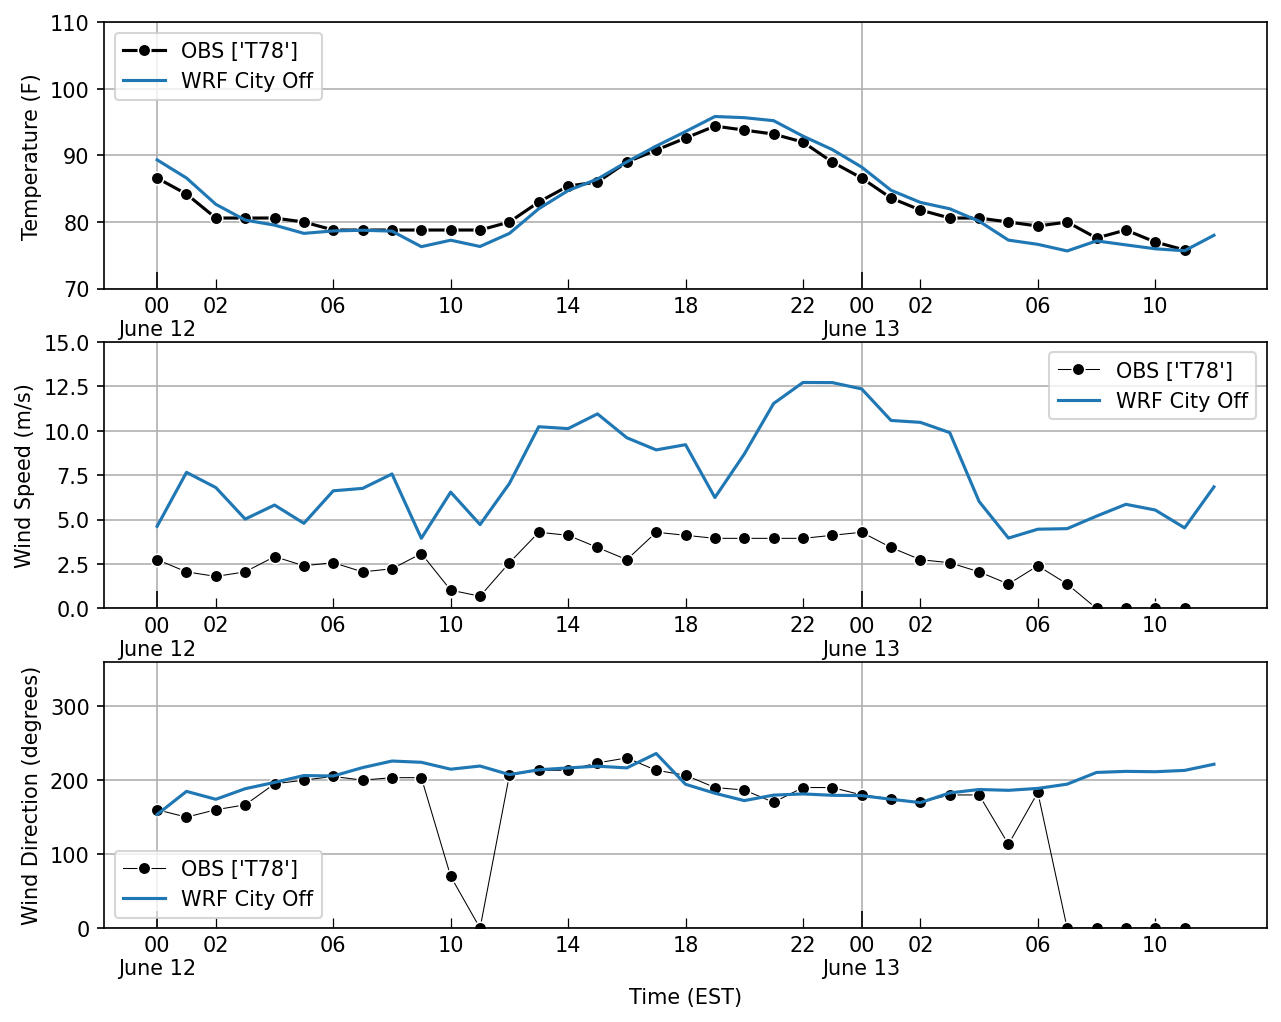

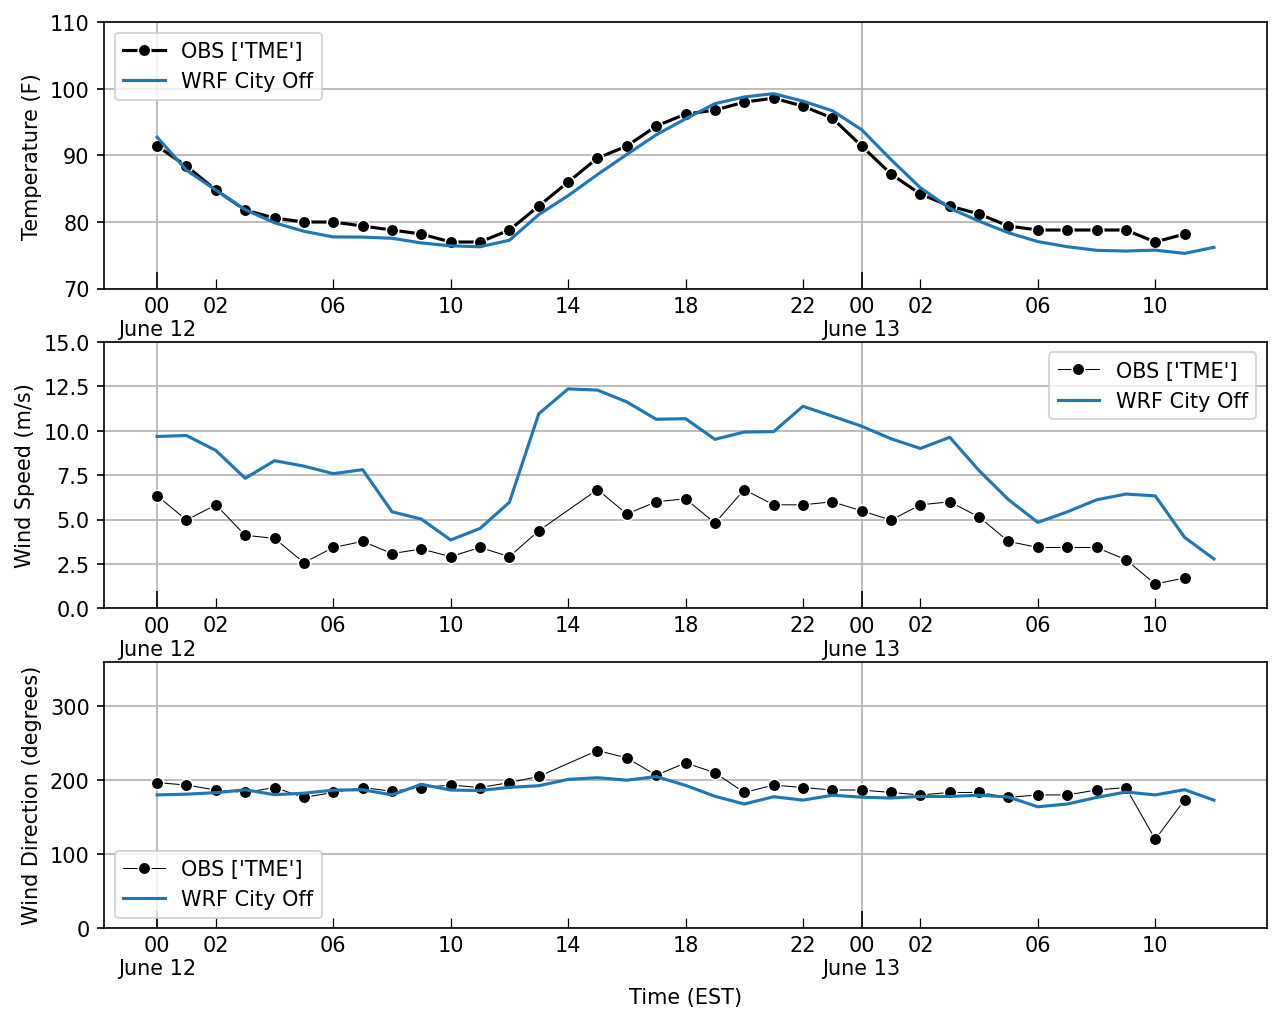

In [ ]:
for sta_id in range(0 ,27):

    time_plot = pd.to_datetime(df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]]['DATETIME']) 
    wrf_time_plot = pd.to_datetime(df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]]['DATETIME']) 

    label_plot = 'OBS ' +  str(df_resamp_filt.loc[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id] , 'Station'][:1].to_numpy())

    obs_plot = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['Temperature'] 
    Case_A_plot = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WRF_Temp']

    obs_plot_ws = df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WSpeed']
    Case_A_plot_ws =df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WRF_WSpeed']

    obs_plot_wd = df_resamp_filt [df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WDir']
    Case_A_plot_wd =df_resamp_filt[df_resamp_filt['Station'] == df_resamp_filt['Station'].unique()[sta_id]] ['WRF_WDir']


    fig, axes = plt.subplots(3,1,figsize=(10, 8))
    ax = axes[0]
    # ax.set_xlim([datetime(2018, 6, 29,0,0),datetime(2018, 7, 3, 0, 0)])
    ax.set_ylim([70,110])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot, ax =ax , label=label_plot,marker="o" , color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot,ax =ax ,color = 'tab:blue', label='WRF City Off')  # stat_id = '134,133 ' 
    ax.legend(loc=2)
    ax.set(xlabel=None)

    ax.set_ylabel('Temperature (F)', fontsize=10)


    ax = axes[1]
    ax.set_ylim([0,15])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax1 = sns.lineplot(time_plot, obs_plot_ws ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_ws ,ax =ax , color = 'tab:blue', label='WRF City Off')  # stat_id = '134,133 ' 
    ax.set_ylabel('Wind Speed (m/s)', fontsize=10)
    #     ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=0)
    ax.set(xlabel=None)

    ax = axes[2]
    ax.set_ylim([0,360])

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%B %d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

    ax.tick_params(axis="x",which = 'major', direction='in' ,  length=8)
    ax.tick_params(axis="x",which = 'minor', direction='in',  length=5)
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True)

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax1 = sns.lineplot(time_plot, obs_plot_wd ,ax =ax , label=label_plot,marker="o" ,linewidth = 0.5, color = 'black')  # stat_id = '134,133 ' 
    ax2 = sns.lineplot(wrf_time_plot, Case_A_plot_wd ,ax =ax , color = 'tab:blue', label='WRF City Off')  # stat_id = '134,133 ' 

    ax.set_ylabel('Wind Direction (degrees)', fontsize=10)
    ax.set_xlabel('Time (EST)', fontsize=10)
    ax.legend(loc=3)